In [1]:
# Libraries

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Using TensorFlow backend.


In [2]:
pd.set_option('display.max_rows', 1024)   #设置最大显示行数
pd.set_option('display.max_columns', 1024) #设置最大显示列数

In [3]:
#导入数据文件
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

In [4]:
#将nan转成{}
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

print(train.head())

   id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                 {}   3300000   
3   4                                                 {}   1200000   
4   5                                                 {}         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash

In [5]:
#查看数据的维度
print(train.shape)
print(test.shape)

(3000, 23)
(4398, 22)


### belongs_to_collection属性

In [6]:
#比较容易发现有些属性是字典属性，因此还需要进行处理,但并不是所有的行都有数据
 
print(train['belongs_to_collection'][0:5])
for i,e in enumerate(train['belongs_to_collection'][0:10]):
    print(i,e)

train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                   {}
3                                                   {}
4                                                   {}
Name: belongs_to_collection, dtype: object
0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}
5 {}
6 {}
7 {}
8 [{'id': 256377, 'name': 'The Muppet Collection', 'poster_path': '/8Ew8EIdFFurMMYjSbWPu1Hl4vLX.jpg', 'backdrop_path': '/1AWd3MM90G47mxtD112gRDxSXY9.jpg'}]
9 {}


0    2396
1     604
Name: belongs_to_collection, dtype: int64

belongs_to_collection属性列中有2396行为空，604行的为非空。对于每个非空的属性中可能只有name的属性和是否存在collection这两个属性有用。

In [7]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

### genres属性（类型题材）

In [8]:
for i,e in enumerate(train['genres'][0:5]):
    print(i,e)

print()
#是否存在没有类型题材的行
print(train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts())

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64


类型数量主要集中在2-6的范围之内 0和7的可能是异常点

In [9]:
#将所有训练条目的genres的dict转成一个列表
list_of_genres = list(train['genres'].apply(lambda x:[i['name'] for i in x] if x!={} else []).values)
print(list_of_genres)
print(len(list_of_genres))

[['Comedy'], ['Comedy', 'Drama', 'Family', 'Romance'], ['Drama'], ['Thriller', 'Drama'], ['Action', 'Thriller'], ['Animation', 'Adventure', 'Family'], ['Horror', 'Thriller'], ['Documentary'], ['Action', 'Comedy', 'Music', 'Family', 'Adventure'], ['Comedy', 'Music'], ['Drama'], ['Comedy'], ['Drama'], ['Comedy', 'Crime'], ['Action', 'Thriller', 'Science Fiction', 'Mystery'], ['Action', 'Crime', 'Drama'], ['Horror', 'Thriller'], ['Drama', 'Romance'], ['Comedy', 'Romance'], ['Action', 'Thriller', 'Crime'], ['Adventure', 'Family', 'Science Fiction'], ['Horror', 'Thriller'], ['Thriller', 'Horror'], ['Thriller', 'Mystery', 'Foreign'], ['Horror', 'Comedy'], ['Comedy', 'Horror', 'Mystery', 'Thriller'], ['Crime', 'Drama', 'Mystery', 'Thriller'], ['Drama', 'Comedy', 'Romance'], ['Animation'], ['Action', 'Adventure', 'Crime', 'Thriller'], ['Drama', 'Comedy'], ['Mystery', 'Drama', 'Thriller'], ['Fantasy', 'Action', 'Adventure'], ['Horror'], ['Action', 'Comedy', 'Crime', 'Thriller'], ['Action', 'Cri

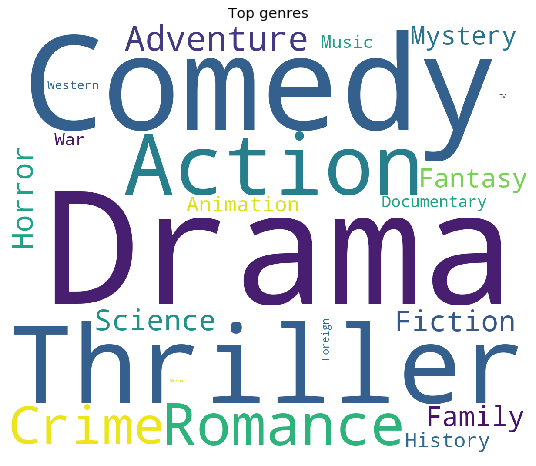

In [10]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()


In [11]:
Counter([i for j in list_of_genres for i in j]).most_common()


[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

可以看到comedy、Drama、Thriller是使用最多的类型。
给每个类型单独设置一个属性表示是否有该类型，并添加类型数量的feature

In [12]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)
print(train.head())

   id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the d

### production_companies属性

In [13]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)
    
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()


0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}
Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

可以看到 制作公司的属性数量集中在1-6个的，绝大多数有1-3个制作公司，但是也有存在10+个制作公司的电影。

In [14]:
train[train['production_companies'].apply(lambda x:len(x) if x!={} else 0)>11]

id    budget                                           homepage  \
31      32         0                        http://www.cache-derfilm.at   
116    117         0                                                NaN   
363    364  15400000                                                NaN   
392    393         0                                                NaN   
449    450  80000000             http://asoundofthunder.warnerbros.com/   
554    555  14500000                                                NaN   
1079  1080   7000000                                                NaN   
2170  2171   4000000  http://tickets.picturehouseentertainment.co.uk...   
2395  2396         0                                                NaN   
2517  2518  97250400  http://www.asterixauxjeuxolympiques.com/index.php   

        imdb_id original_language               original_title  \
31    tt0387898                fr                        Caché   
116   tt2113822                zh                         一九四二   
363   tt2053425                fr           De rouille et d'os   
392   tt5072406                fr                         Moka   
449   tt0318081                en           A Sound of Thunder   
554   tt0293416                ja                   Metropolis   
1079  tt2737050                fr         Deux jours, une nuit   
2170  tt3464902                en                  The Lobster   
2395  tt4082068                fr                      Dheepan   
2517  tt0463872                fr  Astérix aux Jeux Olympiques   

                                               overview  popularity  \
31    A married couple is terrorized by a series of ...    5.695860   
116   In 1942, Henan Province was devastated by the ...    1.678013   
363   Put in charge of his young son, Ali leaves Bel...    8.400049   
392   Diane Kramer is led by one obsession: to find ...    2.404466   
449   When a hunter sent back to the prehistoric era...    4.980191   
554   Duke Red has overseen the construction of a ma...    9.298092   
1079  Sandra is a young woman who has only one weeke...    6.868022   
2170  In a dystopian near future, single people, acc...   11.223033   
2395  Dheepan is a Sri Lankan Tamil warrior who flee...    5.752416   
2517  Ast√©rix and Ob√©lix have to win the Olympic G...    9.671944   

                           poster_path  \
31    /i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg   
116    /xxz2gi8vijqqJySGO3kQy2i8mv.jpg   
363   /cHCwW8xPl8yPKQwpNzKVinwvirT.jpg   
392   /5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg   
449   /gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg   
554   /1EK7mGCpRKYmSg25FaojvnS9opm.jpg   
1079  /1mYAejpMskvskGr0J0SaBvdjmrH.jpg   
2170  /yR60EqMGS9hHq9I5Pkq2hG984TP.jpg   
2395  /lgONuekbRlM0eMvMHJBEDL6MsBP.jpg   
2517  /tKL0RJOeuccc1rrpcDKg8qhedIz.jpg   

                                   production_companies  \
31    [{'name': 'Les Films du Losange', 'id': 223}, ...   
116   [{'name': 'Emperor Motion Pictures', 'id': 272...   
363   [{'name': 'France 2 Cinéma', 'id': 83}, {'name...   
392   [{'name': 'Canal+', 'id': 5358}, {'name': 'Cin...   
449   [{'name': 'Epsilon Motion Pictures', 'id': 117...   
554   [{'name': 'Bandai Visual Company', 'id': 528},...   
1079  [{'name': 'BIM Distribuzione', 'id': 225}, {'n...   
2170  [{'name': 'Haut et Court', 'id': 726}, {'name'...   
2395  [{'name': 'France 2 Cinéma', 'id': 83}, {'name...   
2517  [{'name': 'Constantin Film', 'id': 47}, {'name...   

                                   production_countries release_date  runtime  \
31    [{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...       5/2/05    117.0   
116             [{'iso_3166_1': 'CN', 'name': 'China'}]      11/1/12    145.0   
363   [{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...      5/17/12    123.0   
392   [{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...      8/17/16     89.0   
449   [{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...      5/15/05    110.0   
554             [{'iso_3166_1': 'JP', 'name': 'Japan'}]      5/26/01    10

公司列表

In [15]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

统计最常见的前30名的制作公司

In [16]:
Counter([i for j in list_of_companies for i in j]).most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

添加属性（是否拥有前30的制作公司、拥有哪些公司、拥有制作公司的总数）

In [17]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

### production_countries

In [18]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)
    
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
Number of production countries in films


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

统计出现次数前25的国家

In [19]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10)]

In [20]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

### Spoken languages

In [21]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)
   

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [22]:
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [23]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)


[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [24]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

### Keywords


In [25]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [26]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

用词汇图找出最常见的形容电影的词汇

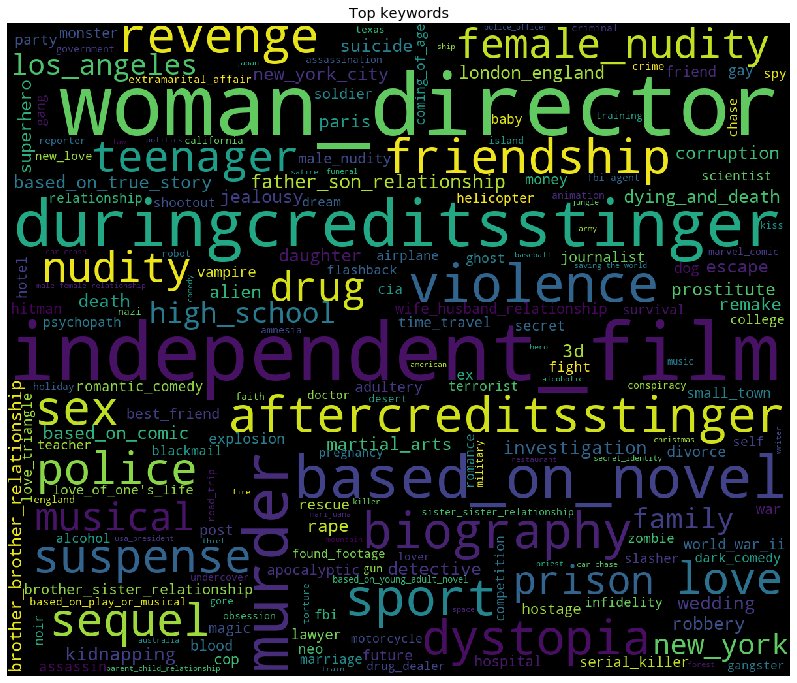

In [27]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

选取前30常见的作为特征

In [28]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

### cast

In [29]:
#train['cast'][0]
for i,e in enumerate(train['cast'][:1]):
    print(i,e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [30]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

最常出现的前15位cast

In [31]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

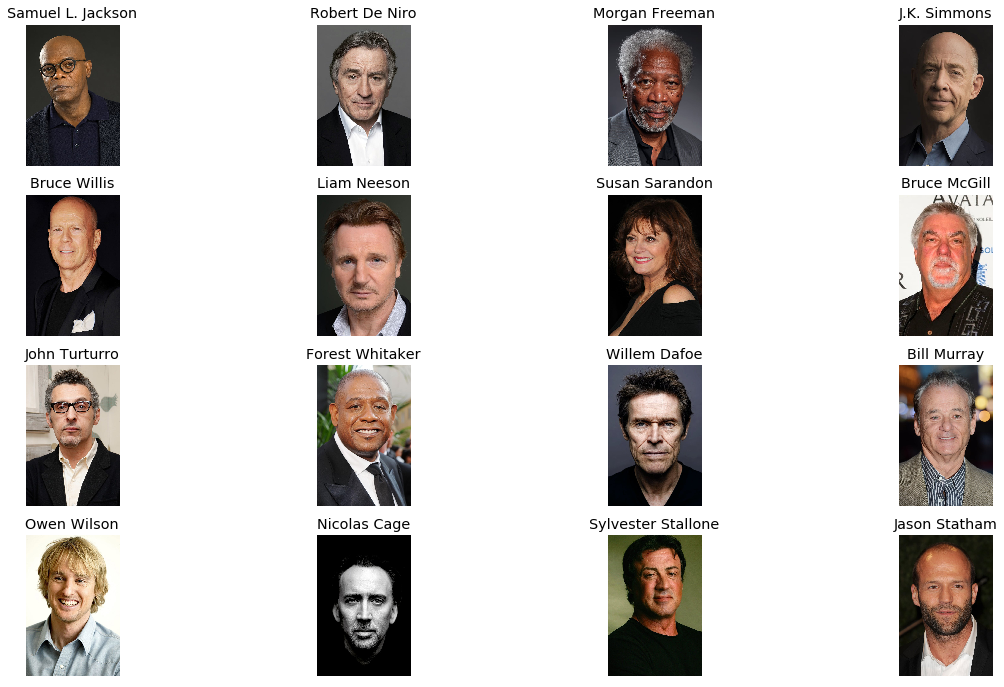

In [32]:
list_of_cast_names_url = list(train['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 12))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
    plt.imshow(im)
    ax.set_title(f'{p[0]}')

In [33]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

0是未知定，1为female，2为male

In [34]:
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

In [35]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

### crew（参照cast）

In [36]:
for i, e in enumerate(train['crew'][:1]):
    print(i, e[:10])

print('Number of casted persons in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

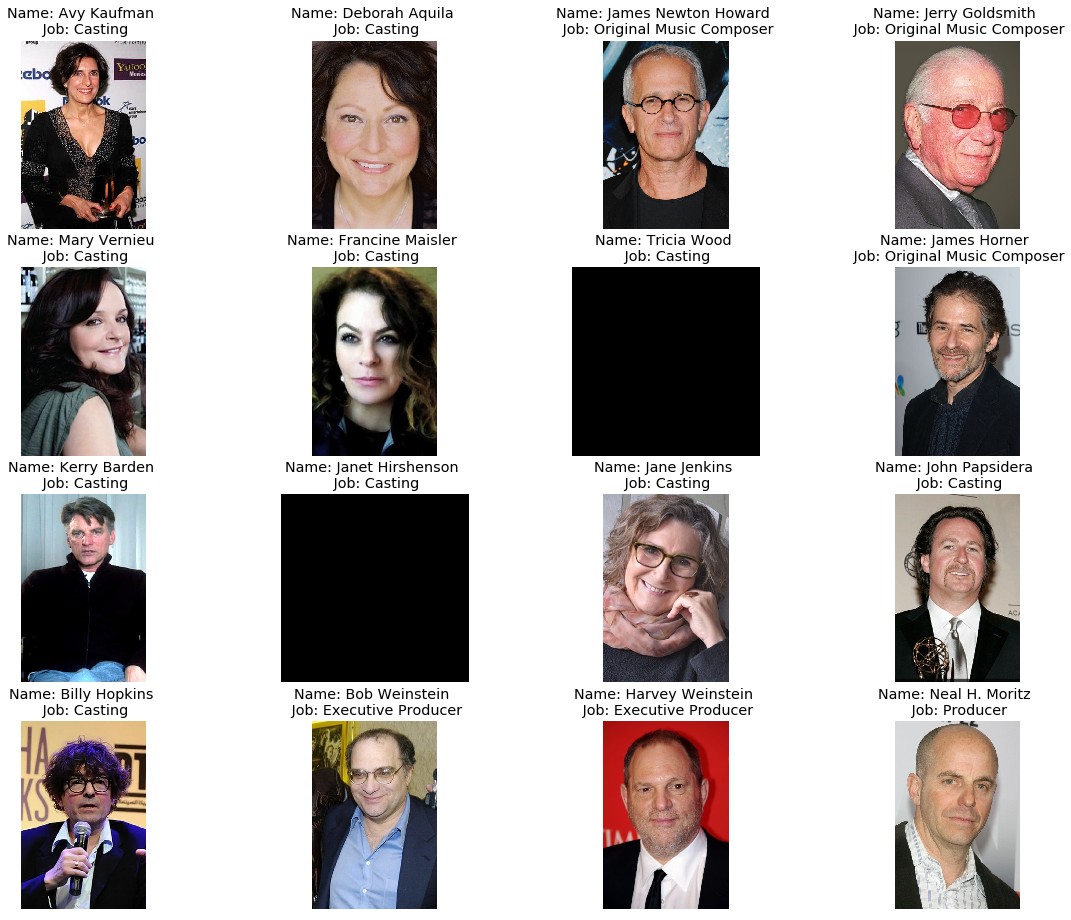

In [37]:
list_of_crew_names_url = list(train['crew'].apply(lambda x: [(i['name'], i['profile_path'], i['job']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_crew_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 16))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    if p[1]:
        im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
    else:
        im = Image.new('RGB', (5, 5))
    plt.imshow(im)
    ax.set_title(f'Name: {p[0]} \n Job: {p[2]}')

In [38]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [39]:
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

In [40]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

In [41]:
list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [42]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['crew_character_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['crew_character_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

## Data Exploration

In [43]:
train.head()

id    budget                           homepage    imdb_id  \
0   1  14000000                                NaN  tt2637294   
1   2  40000000                                NaN  tt0368933   
2   3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3   4   1200000         http://kahaanithefilm.com/  tt1821480   
4   5         0                                NaN  tt1380152   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   
2                en                                  Whiplash   
3                hi                                   Kahaani   
4                ko                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path release_date  runtime    status  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0  Released   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0  Released   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0  Released   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title   revenue  \
0                    Hot Tub Time Machine 2  12314651   
1  The Princess Diaries 2: Royal Engagement  95149435   
2                                  Whiplash  13092000   
3                                   Kahaani  16000000   
4                                Marine Boy   3923970   

                   collection_name  has_collection  num_genres  \
0  Hot Tub Time Machine Collection               1           1   
1  The Princess Diaries Collection               1           4   
2                                0               0           1   
3                                0               0           2   
4                                0               0           2   

                    all_genres  genre_Drama  genre_Comedy  genre_Thriller  \
0                       Comedy            0             1               0   
1  Comedy Drama Family Romance            1             1               0   
2                        Drama            1             0               0   
3               Drama Thriller            1             0               1   
4              Action Thriller            0             0               1   

   genre_Action  genre_Romance  genre_Crime  genre_Adventure  genre_Horror  \
0             0              0            0                0             0   
1             0              1            0                0             0   
2             0              0            0                0             0   
3             0              0            0                0             0   
4             1              0            0                0             0   

   genre_Science Fiction  genre_Family  genre_Fantasy  genre_Mystery  \
0                      0             0              0              0   
1                      0             1              0              0   
2                      0             0              0              0   
3                      0             0              0              0   
4               

### Revenue

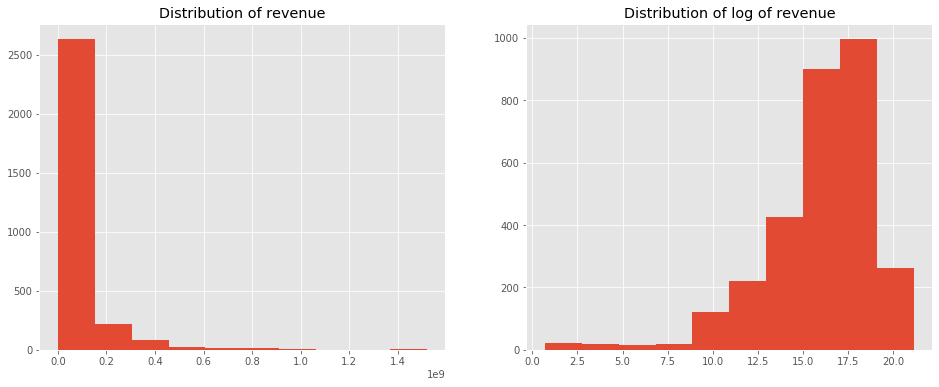

In [44]:
fig,ax = plt.subplots(figsize = (16,6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

revenue的偏移比较严重，因此可以用log将它放缩

In [45]:
train['log_revenue'] = np.log1p(train['revenue'])

### Budget

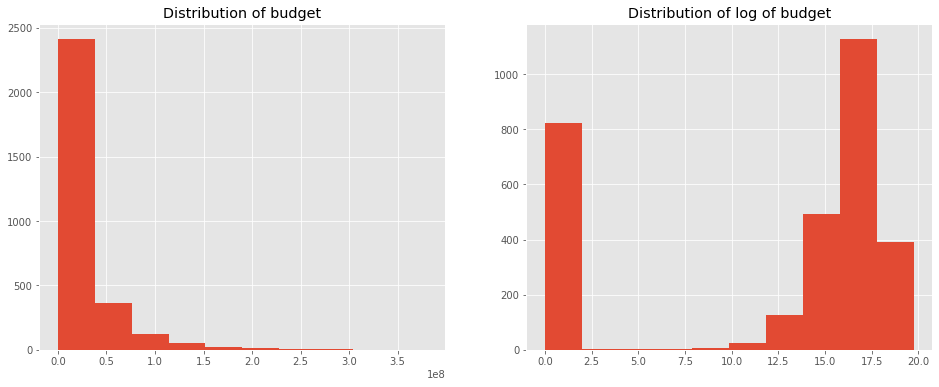

In [46]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

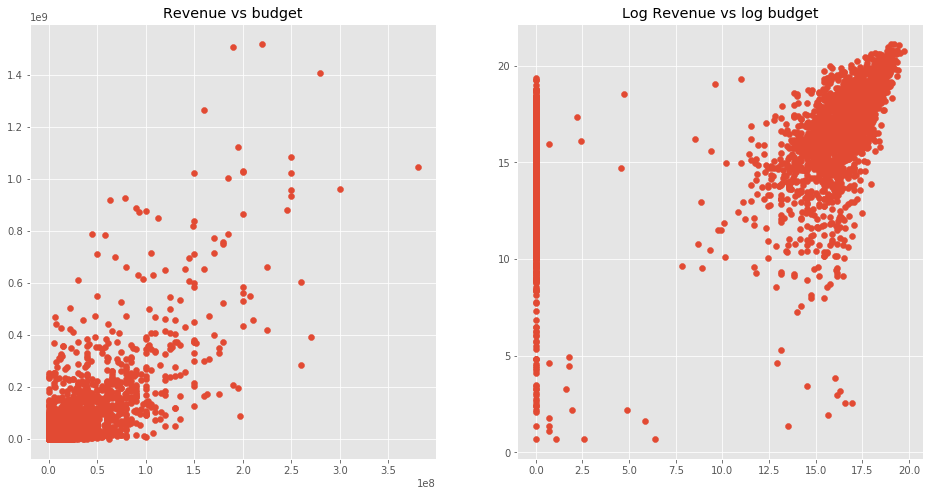

In [47]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

In [48]:
#同样给budget取对数
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

### homepage

In [49]:
train['homepage'].value_counts().head()

http://www.transformersmovie.com/                          4
http://www.thehobbit.com/                                  2
http://www.lordoftherings.net/                             2
http://www.sonypictures.com/homevideo/thefog/index.html    1
http://www.beetlequeen.com/                                1
Name: homepage, dtype: int64

每部电影都有不一样的主页，这个属性可能是冗余的，查看是否有homepage的数量分别有多少。

In [50]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1


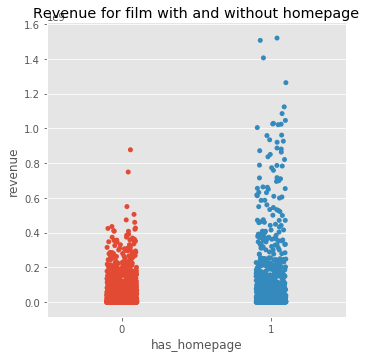

In [51]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

看起来有homepage的电影revenue会更多一些

### original_language

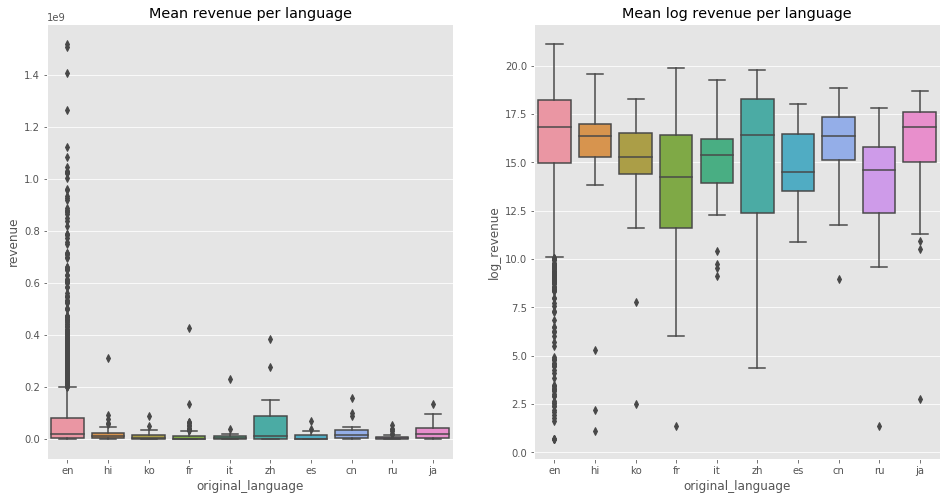

In [52]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

### original_title

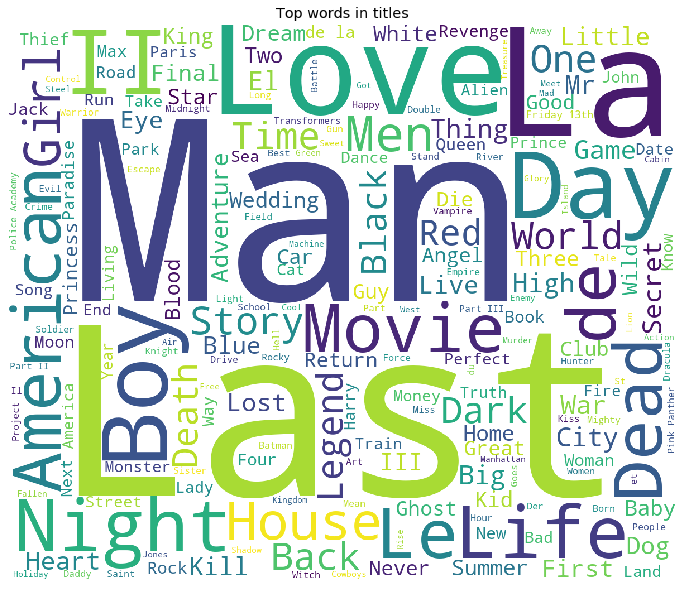

In [53]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

### overview

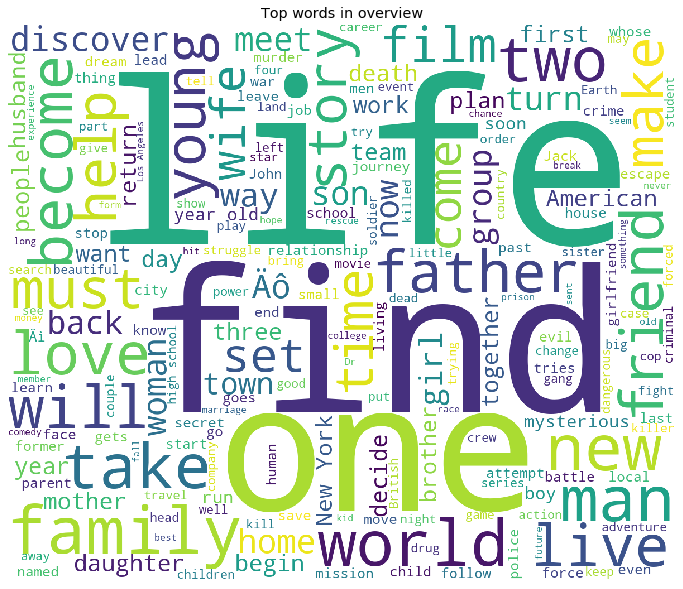

In [54]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

看一下哪些词语会对revenue有影响，使用简单的*ELI5*模型进行分析。

In [55]:
vectorizer =TfidfVectorizer(sublinear_tf=True,
                            analyzer='word',
                            token_pattern=r'\w{1,}',
                            ngram_range =(1,2),
                            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text,train['log_revenue'])
eli5.show_weights(linreg,vec = vectorizer,top = 20,feature_filter = lambda x:x!='<BIAS>')

In [56]:
print('Target value:',train['log_revenue'][1000])
eli5.show_prediction(linreg,doc = train['overview'].values[1000],vec = vectorizer)

Target value: 16.44583954907521


可以看到绿色的是对预测有增益的词，颜色越深则增益越大。红色则相反。

### popularity

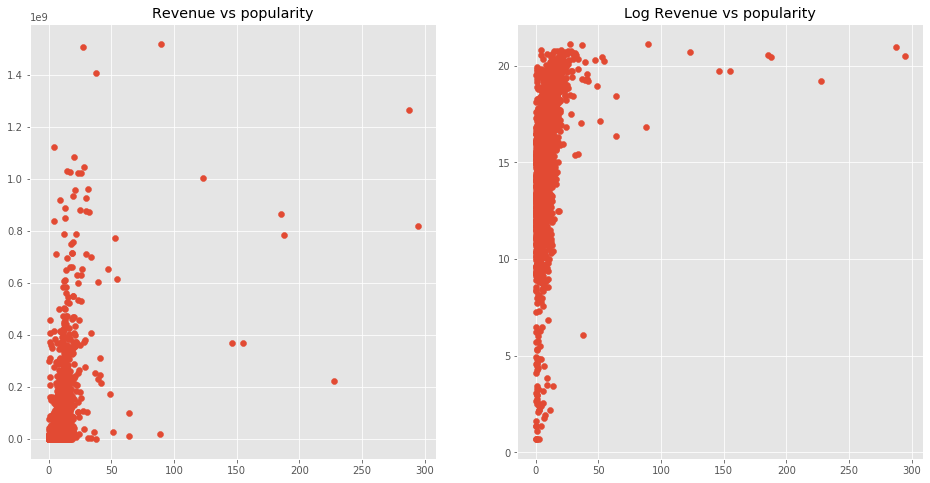

In [57]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.scatter(train['popularity'], train['log_revenue'])
plt.title('Log Revenue vs popularity');

### release_date

In [58]:
#填补缺失值
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

#将年份补充为四位数
def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])


In [59]:
# creating features based on dates
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

train = process_date(train)
test = process_date(test)

In [60]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [61]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [62]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

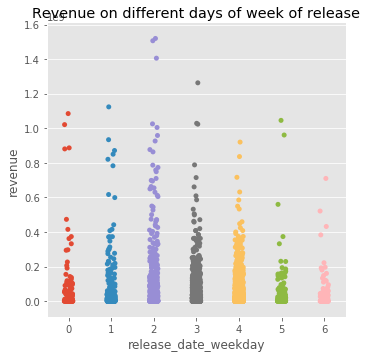

In [63]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

发布在周三或者周四的电影竟然是可以获得更高的revenue的。

### runtime

电影时长

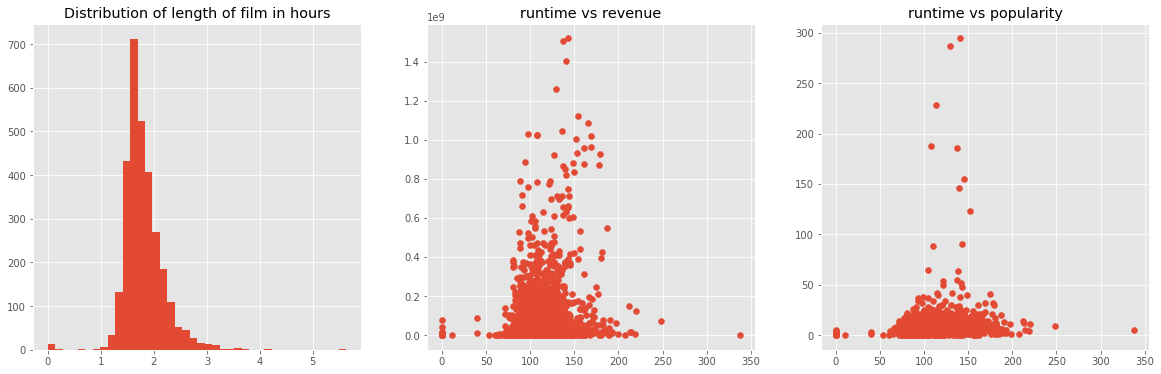

In [64]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

看起来大多数电影时长集中在1.5-2个小时。

### Status

In [65]:
print(train['status'].value_counts())
print()
print(test['status'].value_counts())

Released    2996
Rumored        4
Name: status, dtype: int64

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64


### tagline

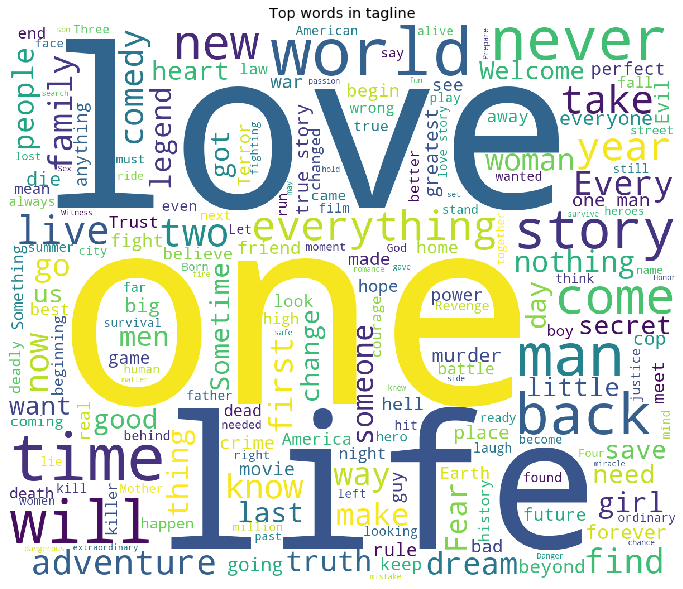

In [66]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

### collections

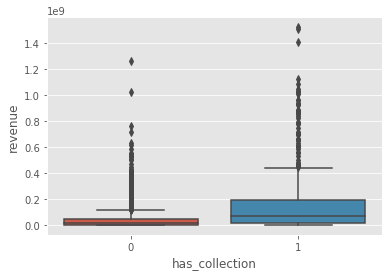

In [67]:
sns.boxplot(x='has_collection', y='revenue', data=train);

### Genres

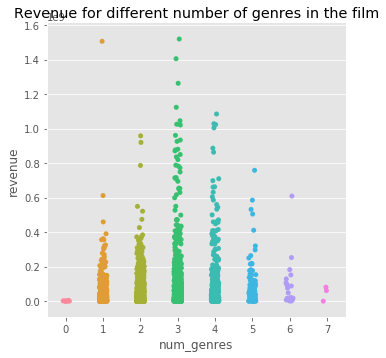

In [68]:
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');

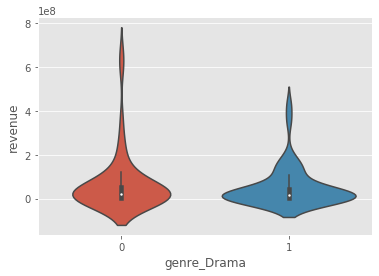

In [69]:
sns.violinplot(x='genre_Drama', y='revenue', data=train[:100]);

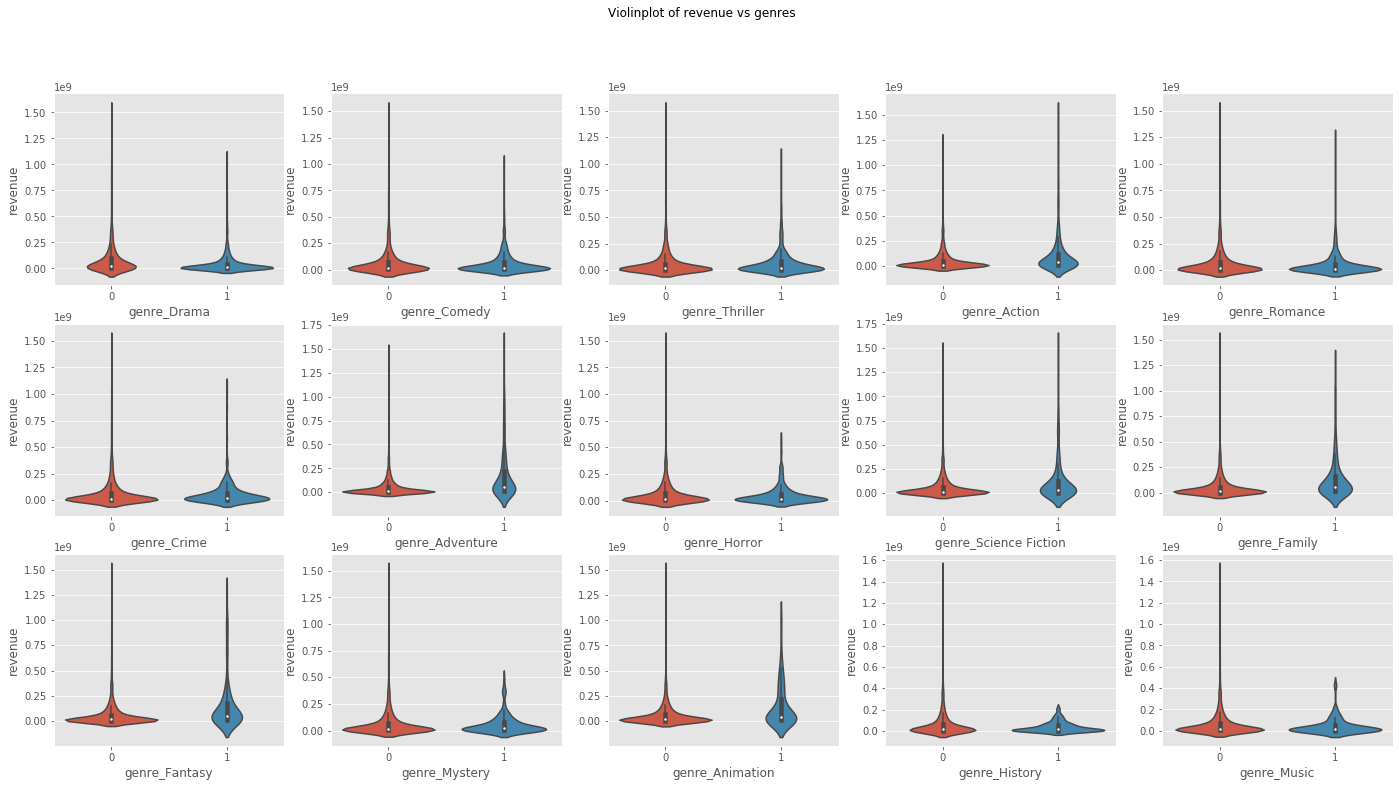

In [70]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

不同的题材还是对revenue有影响的。

### Production contries

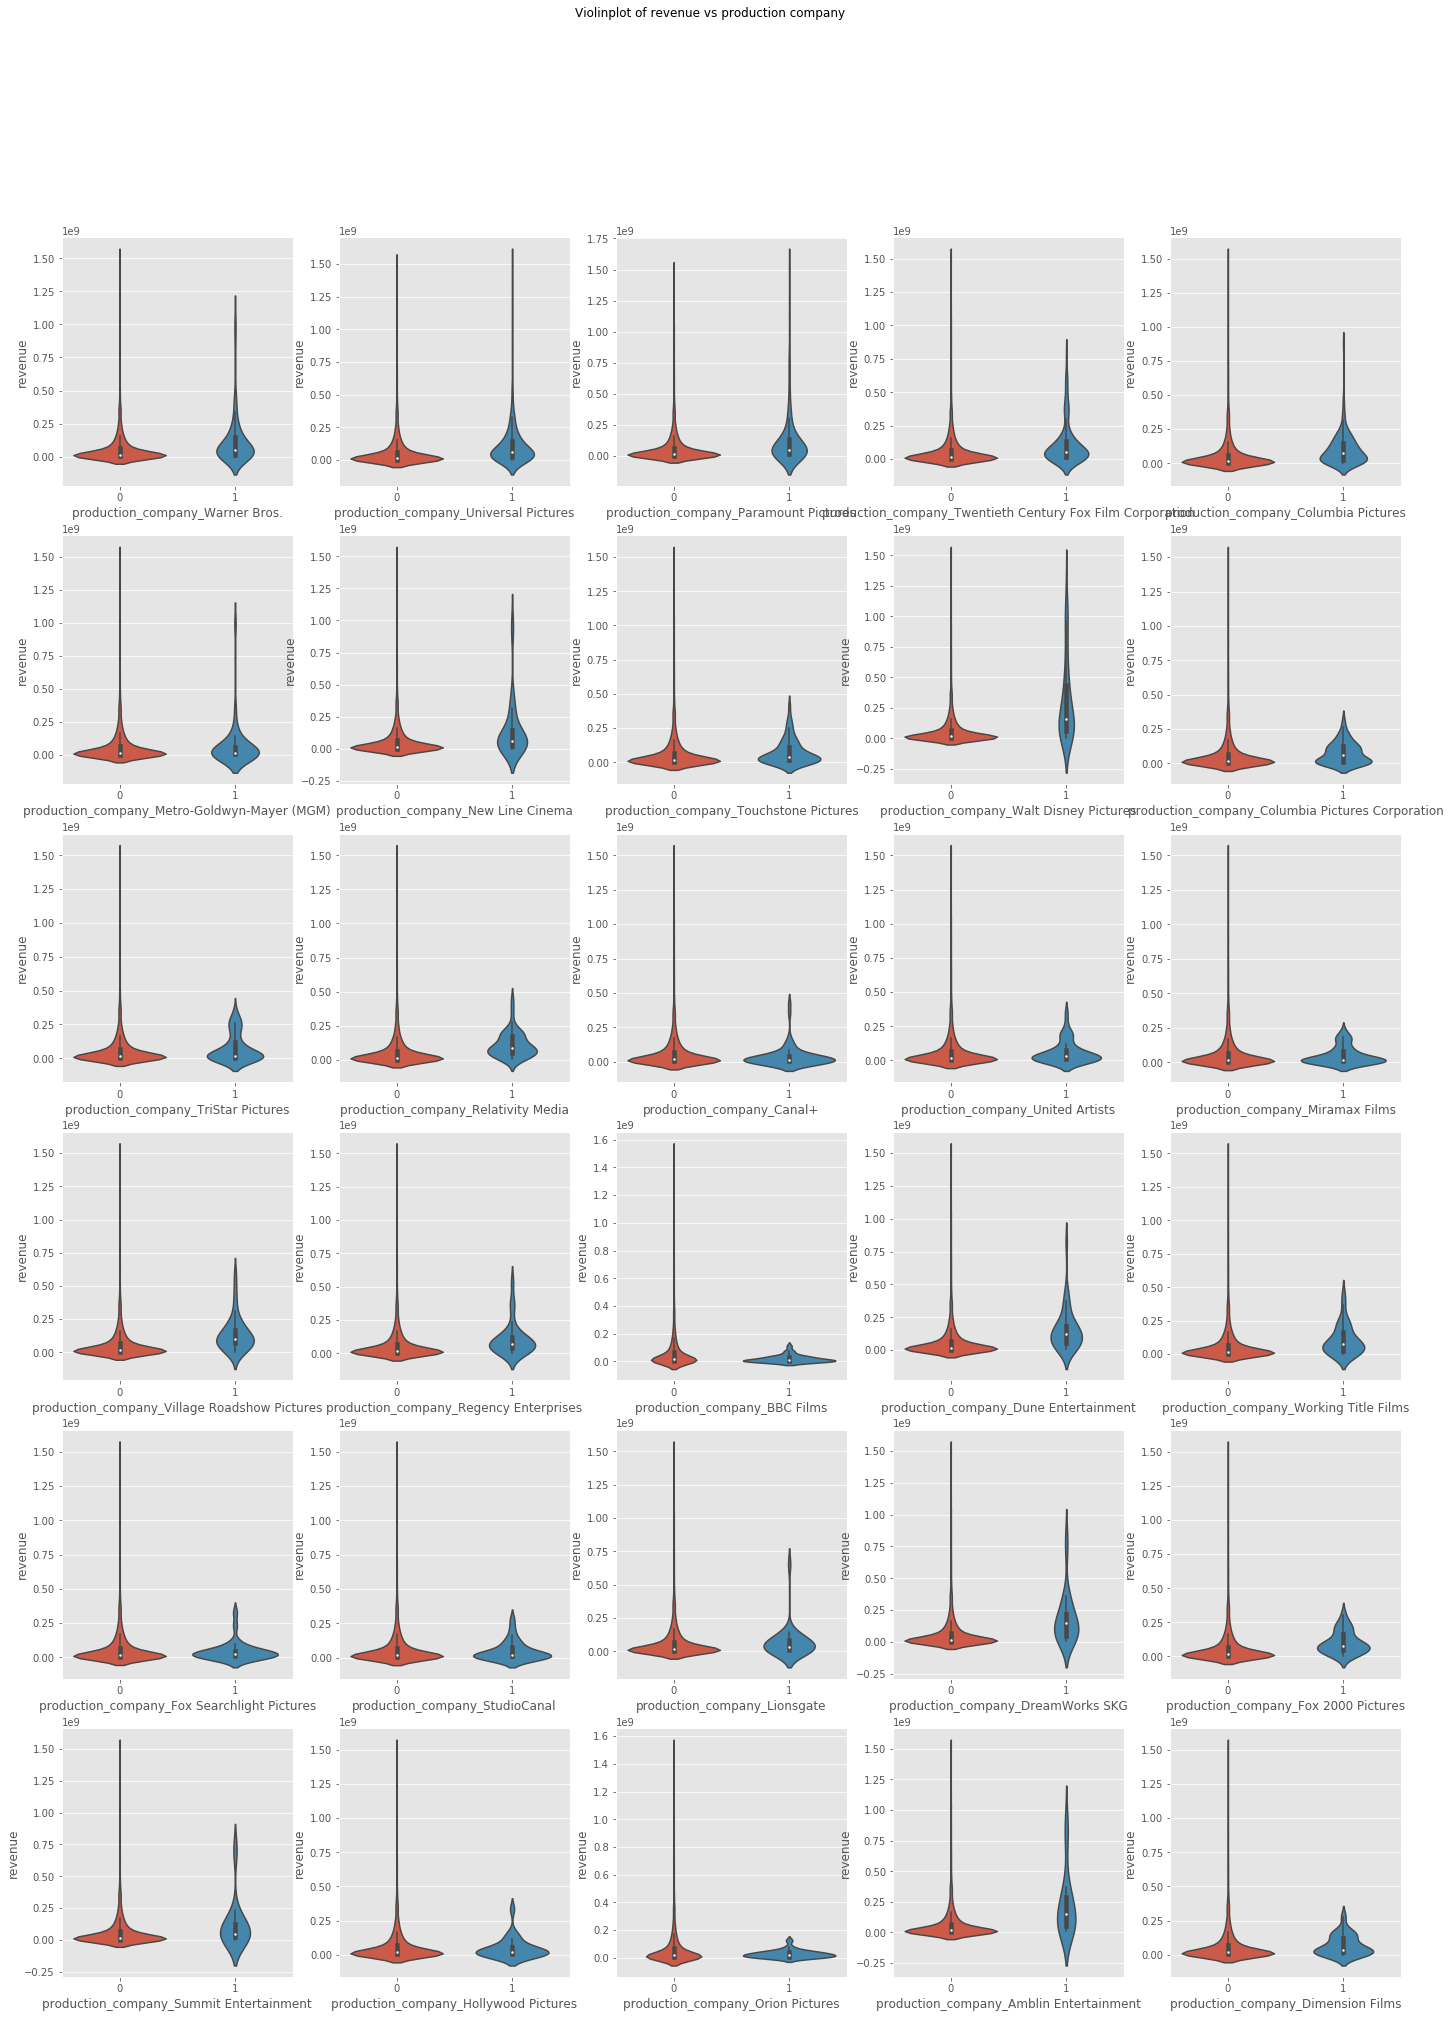

In [71]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in train.columns if 'production_company' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

### Production countries

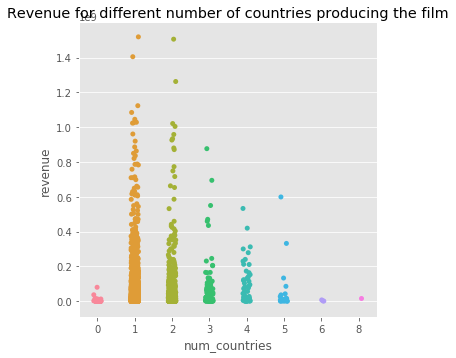

In [72]:
sns.catplot(x='num_countries', y='revenue', data=train);
plt.title('Revenue for different number of countries producing the film');

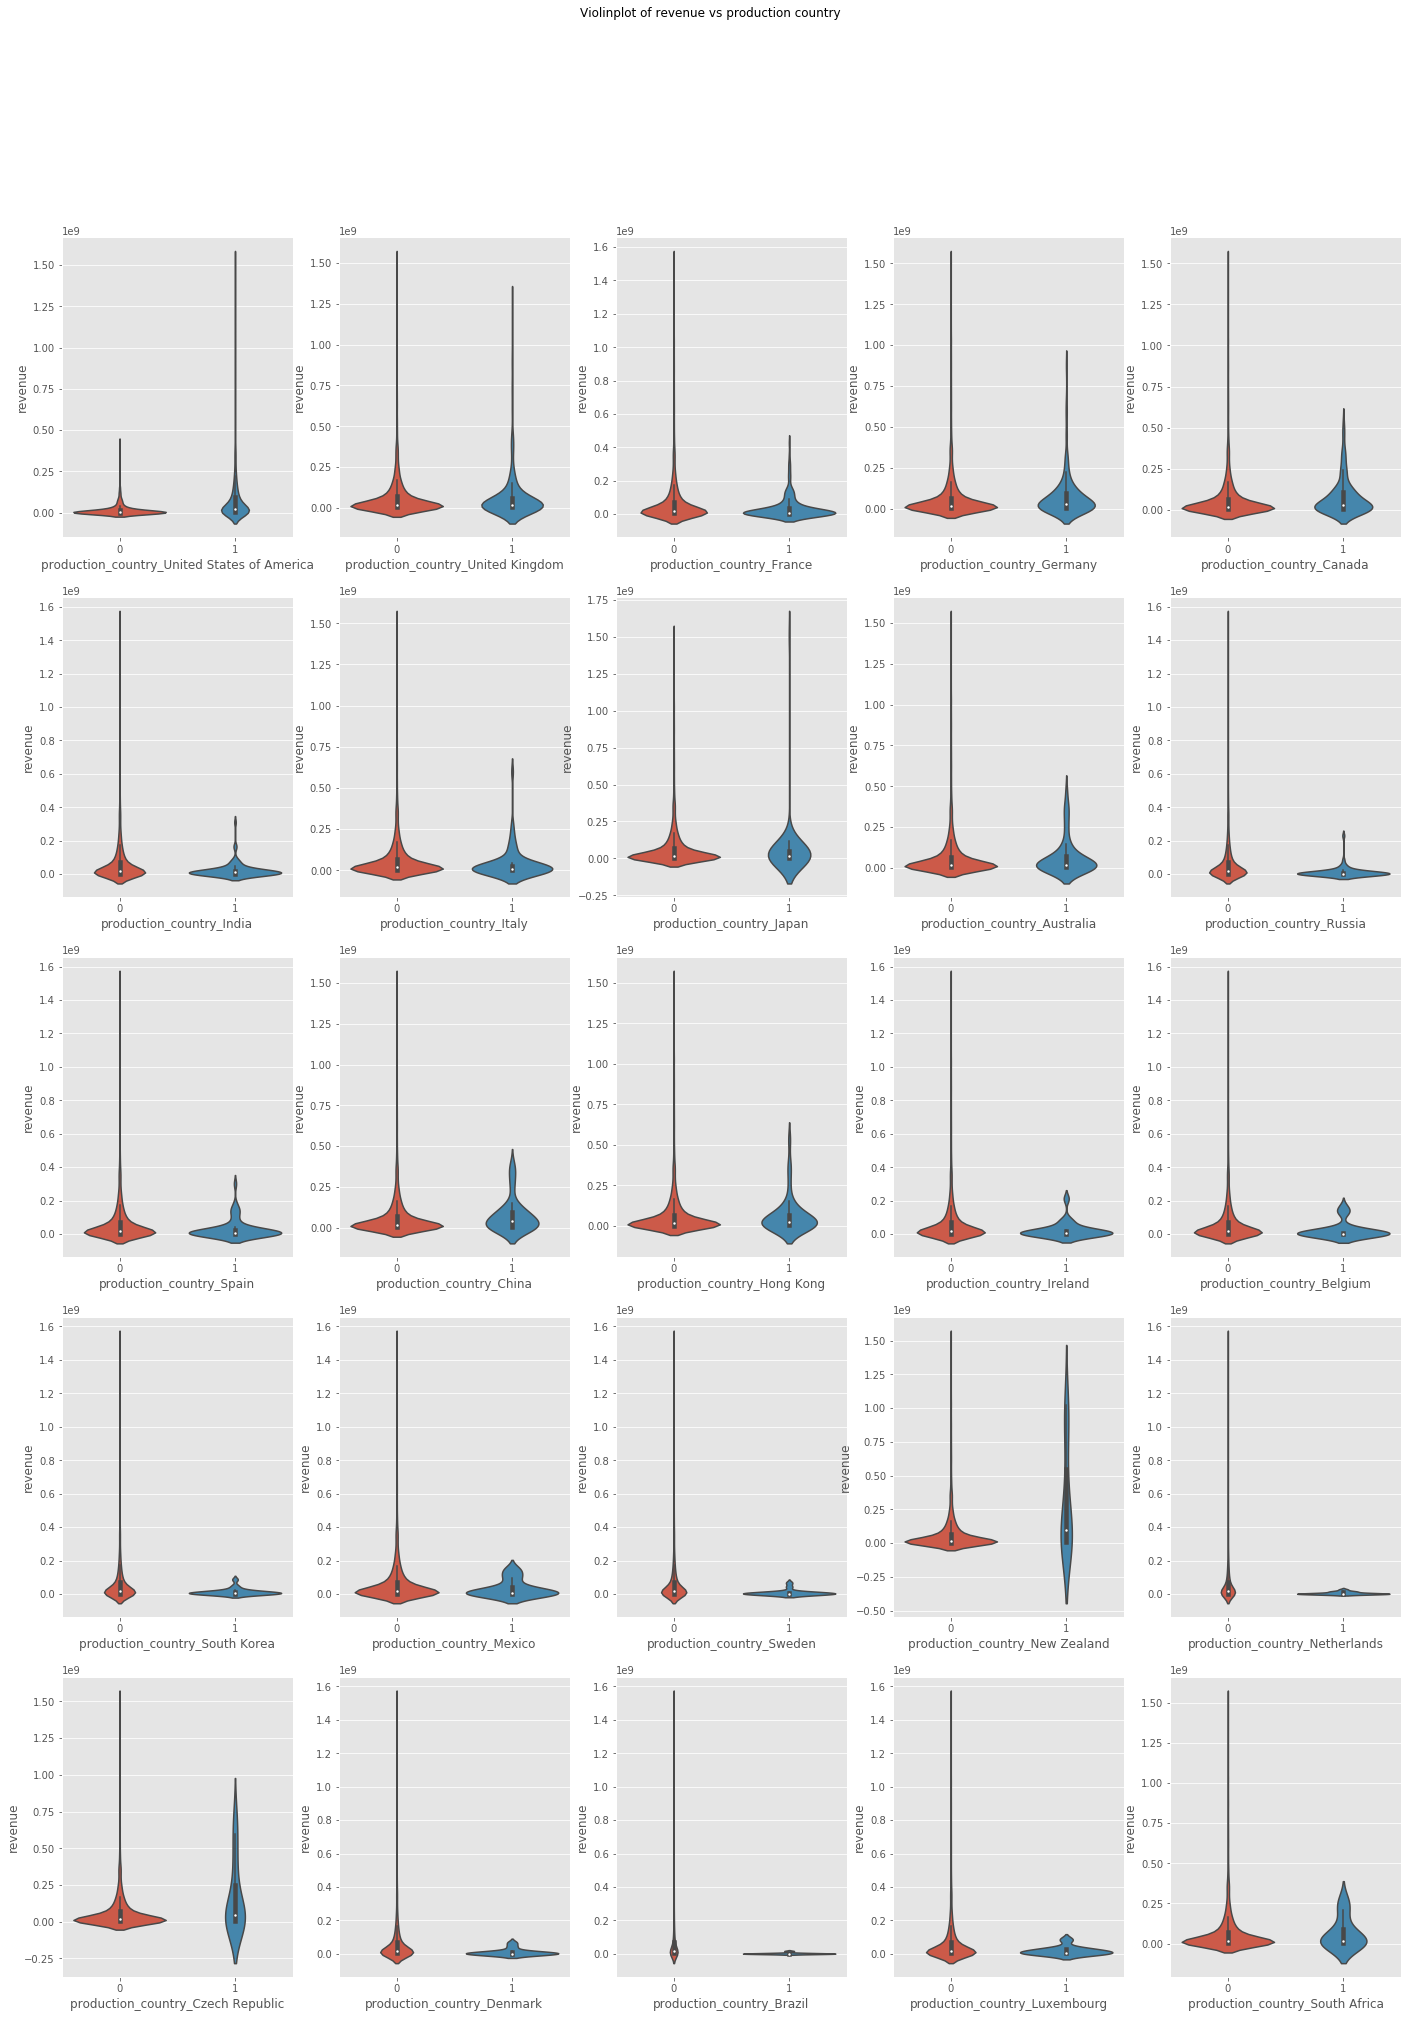

In [73]:
f, axes = plt.subplots(5, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'production_country' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

看起来只有少数的制作国家相较于其他而言才会对revenue有影响。

###  cast


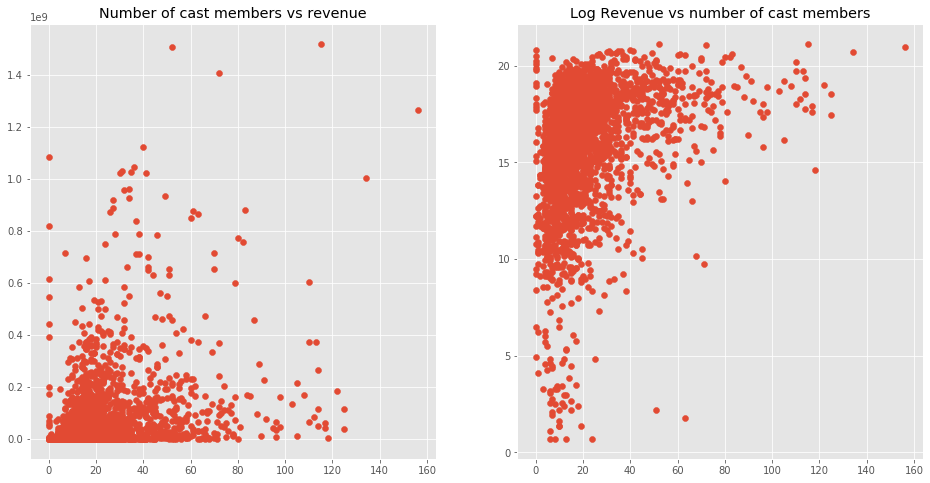

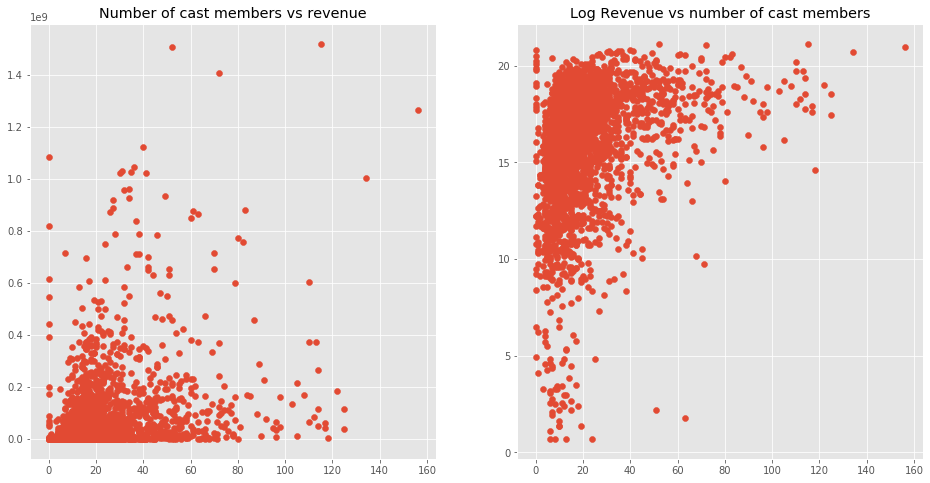

In [74]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'])
plt.title('Number of cast members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_cast'], train['log_revenue'])
plt.title('Log Revenue vs number of cast members');plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'])
plt.title('Number of cast members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_cast'], train['log_revenue'])
plt.title('Log Revenue vs number of cast members');

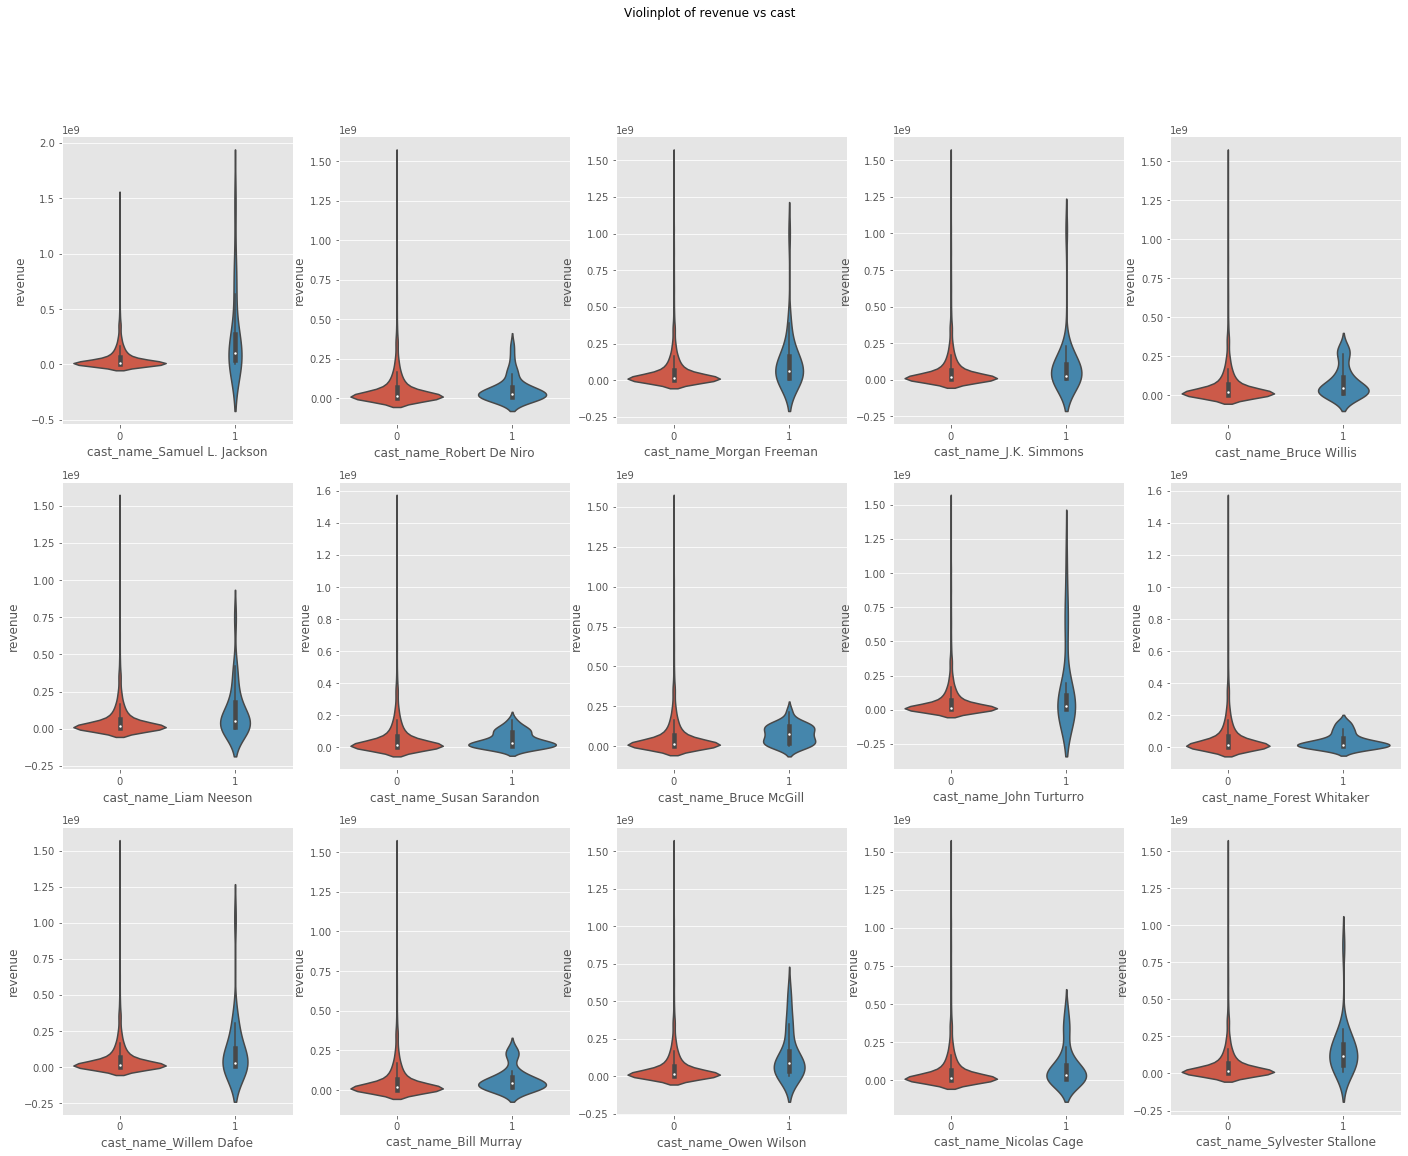

In [75]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_name' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

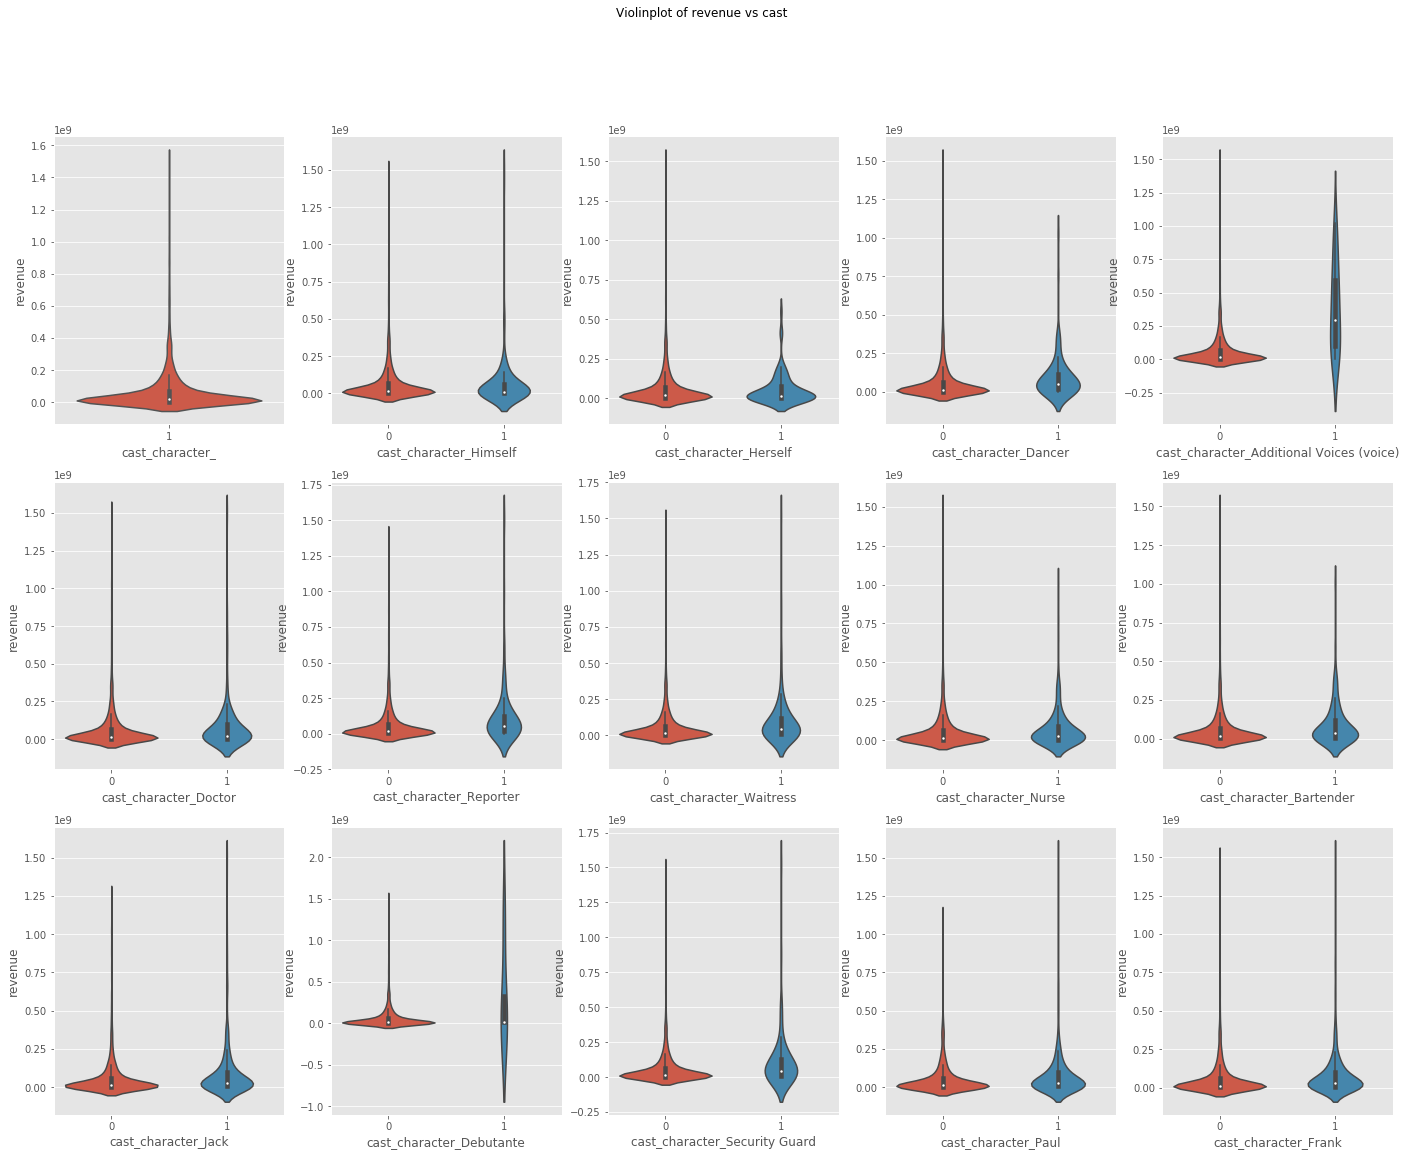

In [76]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

### Keywords

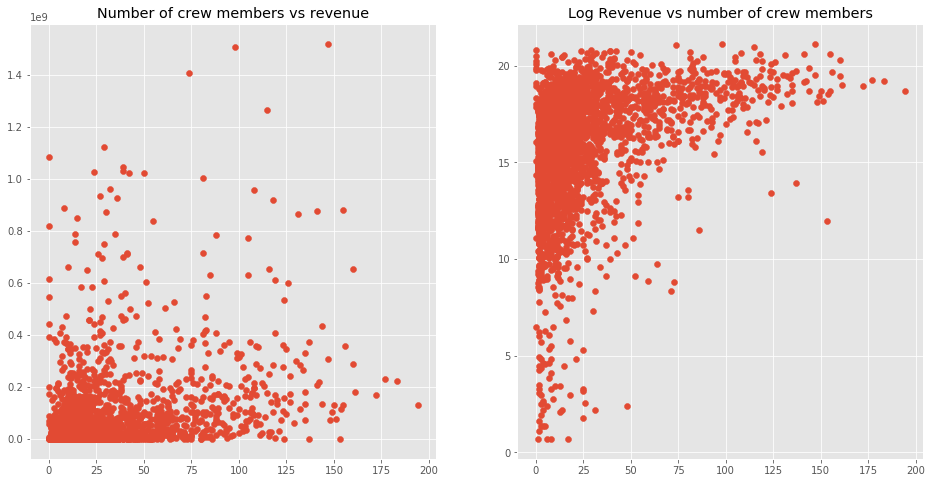

In [77]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_crew'], train['revenue'])
plt.title('Number of crew members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_crew'], train['log_revenue'])
plt.title('Log Revenue vs number of crew members');

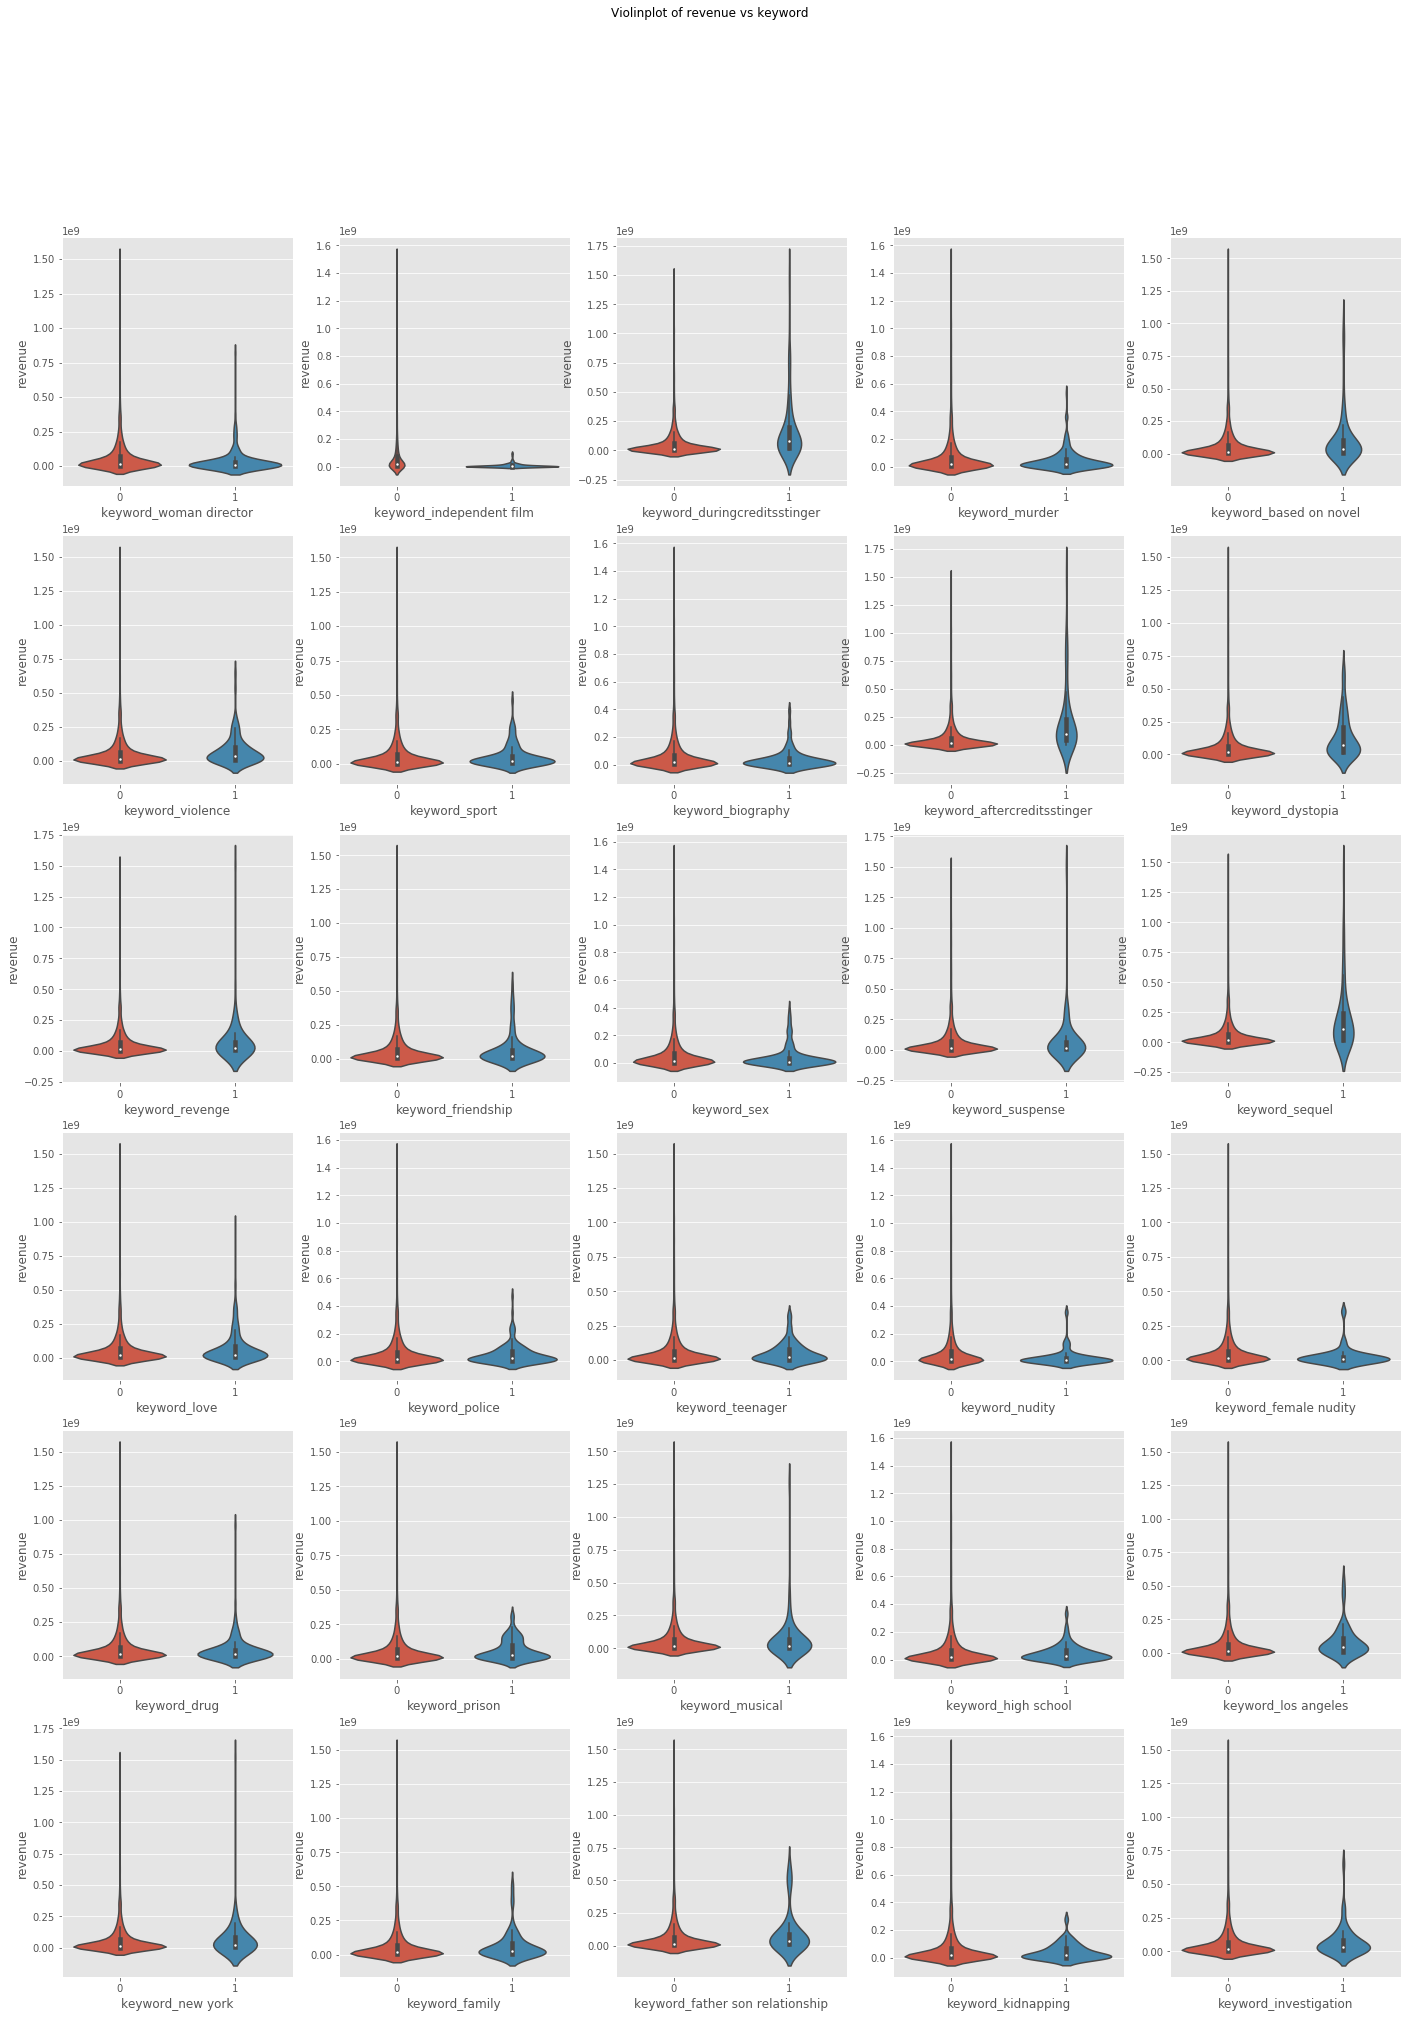

In [78]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs keyword')
for i, e in enumerate([col for col in train.columns if 'keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

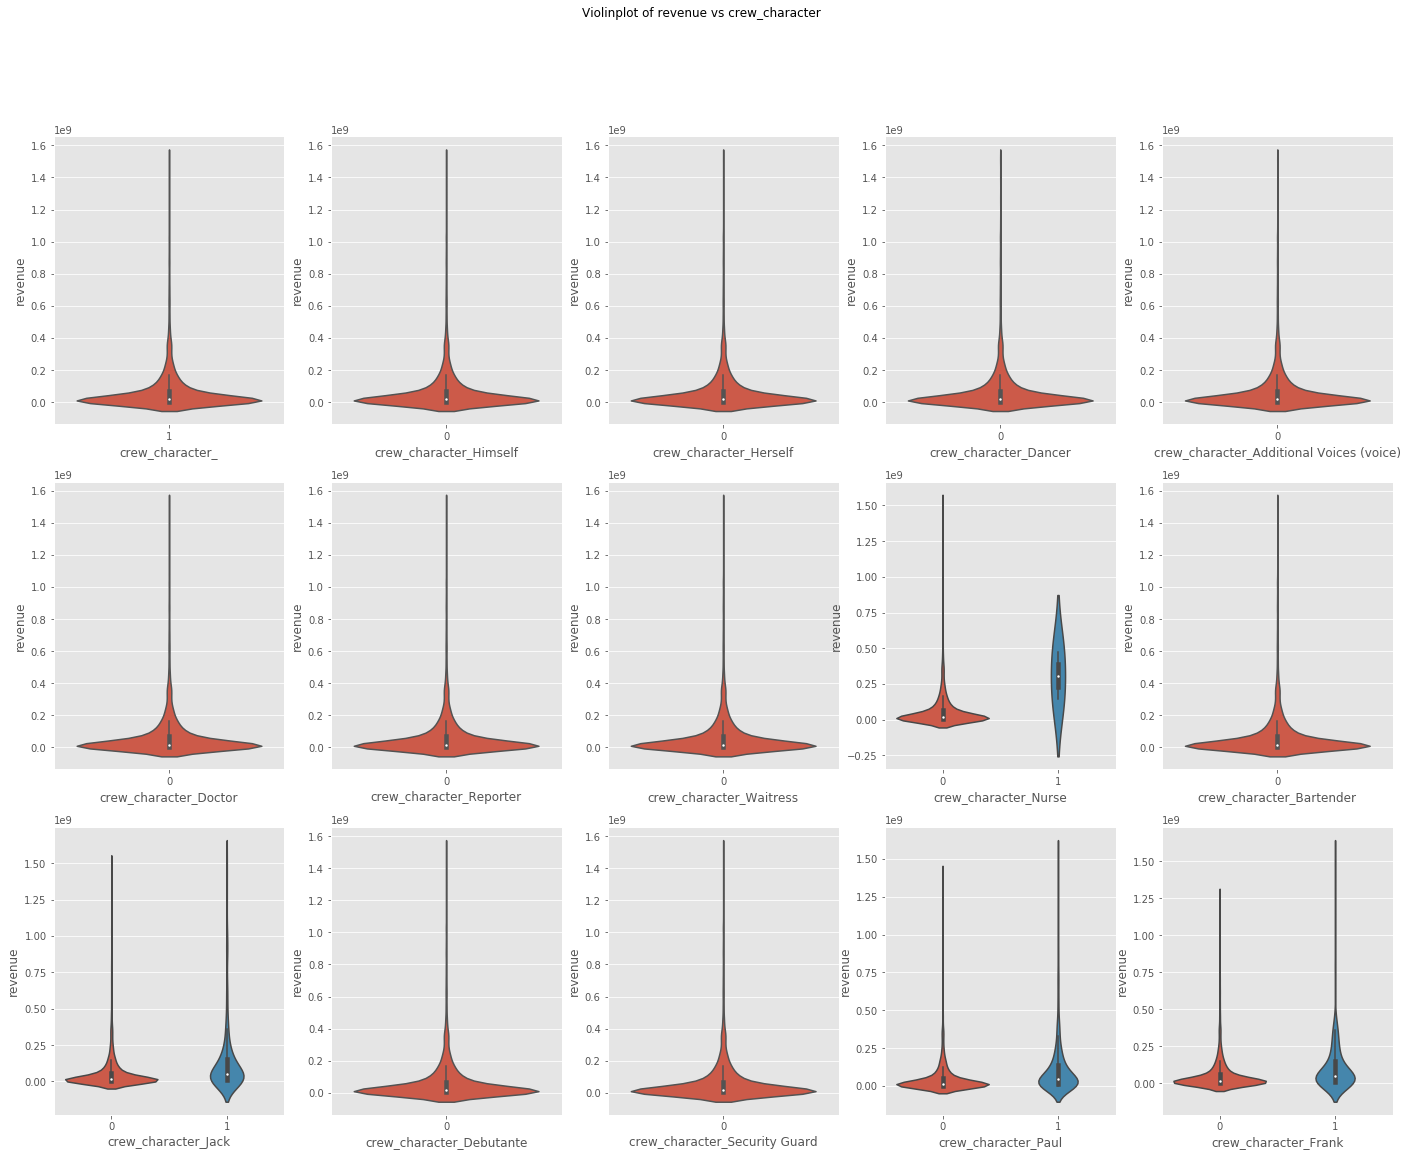

In [79]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs crew_character')
for i, e in enumerate([col for col in train.columns if 'crew_character' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

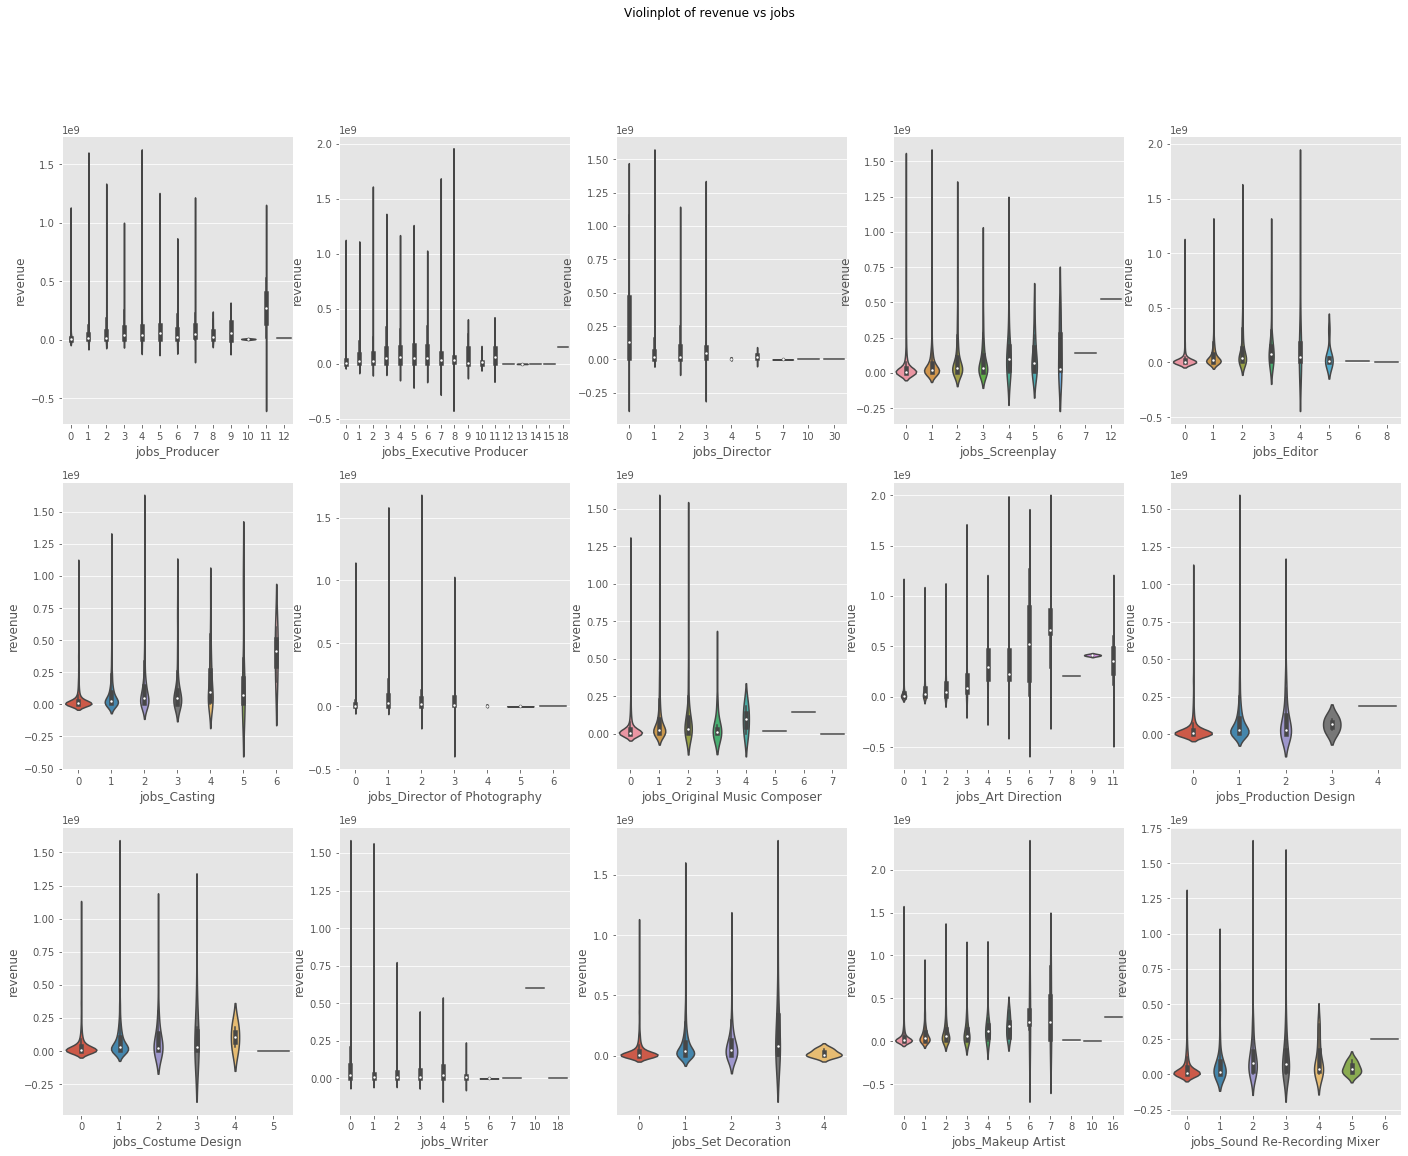

In [80]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs jobs')
for i, e in enumerate([col for col in train.columns if 'jobs_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## 特征生成和模型训练

In [81]:
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
test = test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [82]:
#Pandas nunique() 用于统计每一列属性各自有多少个不同值
for col in train.columns:
    if train[col].nunique() == 1:
        print(col)
        train = train.drop([col], axis=1)
        test = test.drop([col], axis=1)

language_
cast_character_
crew_character_
crew_character_Himself
crew_character_Herself
crew_character_Dancer
crew_character_Additional Voices (voice)
crew_character_Doctor
crew_character_Reporter
crew_character_Waitress
crew_character_Bartender
crew_character_Debutante
crew_character_Security Guard


In [83]:
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))
    print(train[col])
    print()
    print(test[col])

0       10
1       10
2       10
3       16
4       24
        ..
2995    10
2996    35
2997    10
2998    10
2999    10
Name: original_language, Length: 3000, dtype: int64

0       21
1       10
2       10
3       14
4       10
        ..
4393    10
4394    10
4395    10
4396    10
4397    14
Name: original_language, Length: 4398, dtype: int64
0       282
1       641
2         1
3         1
4         1
       ... 
2995      1
2996      1
2997      1
2998      1
2999      1
Name: collection_name, Length: 3000, dtype: int64

0       420
1         1
2         1
3         1
4         1
       ... 
4393      1
4394    731
4395      1
4396      1
4397      1
Name: collection_name, Length: 4398, dtype: int64
0       480
1       516
2       658
3       742
4       295
       ... 
2995    589
2996    718
2997    212
2998    589
2999    285
Name: all_genres, Length: 3000, dtype: int64

0       320
1       789
2       589
3       733
4       651
       ... 
4393    810
4394     48
4395    658
43

In [84]:
train_texts = train[['title','tagline','overview','original_title']]
test_texts = test[['title','tagline','overview','original_title']]

LabelEncoder：将标签分配一个0—n_classes-1之间的编码

##### 对于文字类型的特征 生成长度和对应单词的列

把文本类的变量拿出来

In [85]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    #长度
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    #单词数量
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

In [86]:
###### 数据的修复 
# data fixes from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [87]:
#生成训练集及测试集
#将x的id和revenue目标列删除
X = train.drop(['id','revenue'],axis=1)
y = np.log1p(train['revenue'])
X_test =test.drop(['id'],axis=1)

In [88]:
X_train,X_valid,y_train,y_valid =train_test_split(X,y,test_size = 0.1)

#### lightgbm的训练

In [89]:
params = {
    'num_leaves': 30,
    'min_data_in_leaf': 20,
    'objective': 'regression',
    'max_depth': 5,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "verbosity": -1
}
modellgb = lgb.LGBMRegressor(
    **params,
    n_estimators=20000, 
    nthread = 4,
    n_jobs=-1)

modellgb.fit(X_train,y_train,
            eval_set = [(X_train,y_train),(X_valid,y_valid)],
            eval_metric = 'rmse',
            verbose = 1000,
            early_stopping_rounds = 200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.3028	valid_1's rmse: 2.19419
[2000]	training's rmse: 0.999448	valid_1's rmse: 2.15396
[3000]	training's rmse: 0.793976	valid_1's rmse: 2.14645
Early stopping, best iteration is:
[2975]	training's rmse: 0.799013	valid_1's rmse: 2.14534


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=5, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [90]:
eli5.show_weights(modellgb,feature_filter = lambda x:x!='<BIAS>')

发现budget可能是影响revenue的最重要因素

#### 交叉验证

n_splits：表示划分几等份

shuffle：在每次划分时，是否进行洗牌

①若为Falses时，其效果等同于random_state等于整数，每次划分的结果相同

②若为True时，每次划分的结果都不一样，表示经过洗牌，随机取样的

random_state：随机种子数

In [91]:
n_fold = 10
folds = KFold(n_splits = n_fold,shuffle = True,random_state = 42)

In [92]:
def train_model(X, X_test, y, params=None, folds=folds,
                model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0]) #生成一个跟X行数一样长的零矩阵
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()#生成空矩阵
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            """
                #**动态参数 
                n_estimators=100: 要拟合的树的棵树，可以认为是训练轮数 
                n_jobs=1: 并行运行的多线程数 
                nthread [默认为未设置的最大线程数]并行线程数
                """
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            """
                #eval_metric: 评价指标 rmse - 均方根误差 
                early_stopping_rounds: 提前结束轮数 
                eval_set:训练集与测试集 
                verbose=1000使用详细日志记录级别并将日志记录周期设置为此参数的值
                """
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train) # 使用XGBoost的原生版本需要对数据进行转化
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', 
                                      **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)#reshape(-1,)转换成一行 将对valid的预测结果存成矩阵
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)#每交叉验证一次得到一个loss分数，一共有n_fold个值
        
        prediction += y_pred    #每次预测的结果累加 可能需要.reshape(-1,)  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1#第几次交叉验证的标志
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0) #将每次交叉验证的结果得到的变量importance保存

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Thu Nov 28 12:13:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.18137	valid_1's rmse: 1.83876
Early stopping, best iteration is:
[1235]	training's rmse: 1.09117	valid_1's rmse: 1.836
Fold 1 started at Thu Nov 28 12:13:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.20478	valid_1's rmse: 1.83252
Early stopping, best iteration is:
[1397]	training's rmse: 1.07438	valid_1's rmse: 1.82616
Fold 2 started at Thu Nov 28 12:13:26 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.225	valid_1's rmse: 1.69343
[2000]	training's rmse: 0.912277	valid_1's rmse: 1.6692
Early stopping, best iteration is:
[2446]	training's rmse: 0.804666	valid_1's rmse: 1.66554
Fold 3 started at Thu Nov 28 12:13:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.19348	valid_1's rmse: 1.86353
Early stopping, best itera

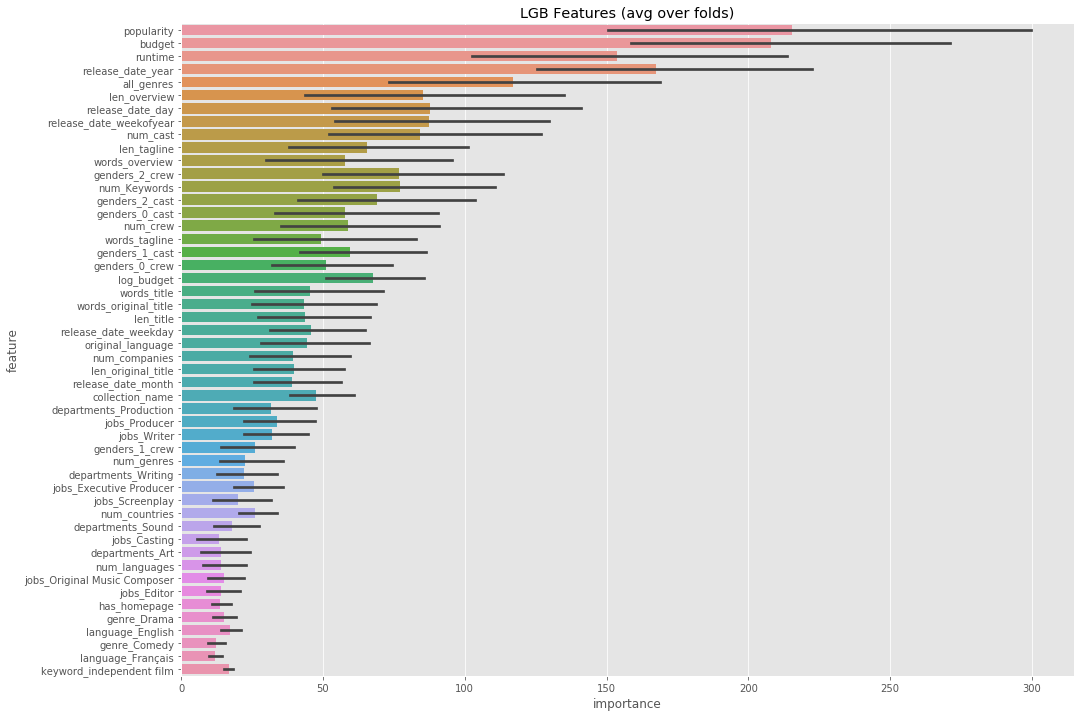

In [93]:
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

#### 基于文本的特征训练

In [94]:
#print(train_texts)
#将文本特征提取出来做回归，计算文本对revenue的贡献作为其值形成新变量
for col in train_texts.columns:
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=10
    )
    vectorizer.fit(list(train_texts[col].fillna('')) + list(test_texts[col].fillna('')))
    train_col_text = vectorizer.transform(train_texts[col].fillna(''))
    test_col_text = vectorizer.transform(test_texts[col].fillna(''))
    model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
    oof_text, prediction_text = train_model(train_col_text, test_col_text, y, params=None, model_type='sklearn', model=model)
    
    X[col + '_oof'] = oof_text
    X_test[col + '_oof'] = prediction_text

Fold 0 started at Thu Nov 28 12:13:48 2019
Fold 1 started at Thu Nov 28 12:13:48 2019
Fold 2 started at Thu Nov 28 12:13:48 2019
Fold 3 started at Thu Nov 28 12:13:48 2019
Fold 4 started at Thu Nov 28 12:13:49 2019
Fold 5 started at Thu Nov 28 12:13:49 2019
Fold 6 started at Thu Nov 28 12:13:49 2019
Fold 7 started at Thu Nov 28 12:13:50 2019
Fold 8 started at Thu Nov 28 12:13:50 2019
Fold 9 started at Thu Nov 28 12:13:50 2019
CV mean score: 2.9692, std: 0.2116.
Fold 0 started at Thu Nov 28 12:13:51 2019
Fold 1 started at Thu Nov 28 12:13:51 2019
Fold 2 started at Thu Nov 28 12:13:52 2019
Fold 3 started at Thu Nov 28 12:13:52 2019
Fold 4 started at Thu Nov 28 12:13:53 2019
Fold 5 started at Thu Nov 28 12:13:53 2019
Fold 6 started at Thu Nov 28 12:13:53 2019
Fold 7 started at Thu Nov 28 12:13:54 2019
Fold 8 started at Thu Nov 28 12:13:54 2019
Fold 9 started at Thu Nov 28 12:13:55 2019
CV mean score: 2.8814, std: 0.1759.
Fold 0 started at Thu Nov 28 12:13:57 2019
Fold 1 started at Thu Nov

#### Additional feature generation 

In [95]:
#添加一些新的特征
def new_features(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    
    # some features from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
    df['_budget_year_ratio'] = df['budget'] / (df['release_date_year'] * df['release_date_year'])
    df['_releaseYear_popularity_ratio'] = df['release_date_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_date_year']
    
    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')
        
    return df

In [96]:
X = new_features(X)
X_test = new_features(X_test)

Fold 0 started at Thu Nov 28 12:14:06 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.13115	valid_1's rmse: 1.81648
Early stopping, best iteration is:
[1423]	training's rmse: 0.975885	valid_1's rmse: 1.81279
Fold 1 started at Thu Nov 28 12:14:08 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.15384	valid_1's rmse: 1.85413
Early stopping, best iteration is:
[1140]	training's rmse: 1.09949	valid_1's rmse: 1.84664
Fold 2 started at Thu Nov 28 12:14:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.17336	valid_1's rmse: 1.74179
[2000]	training's rmse: 0.8409	valid_1's rmse: 1.70497
Early stopping, best iteration is:
[2487]	training's rmse: 0.722449	valid_1's rmse: 1.6968
Fold 3 started at Thu Nov 28 12:14:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.14665	valid_1's rmse: 1.84403
Early stopping, best it

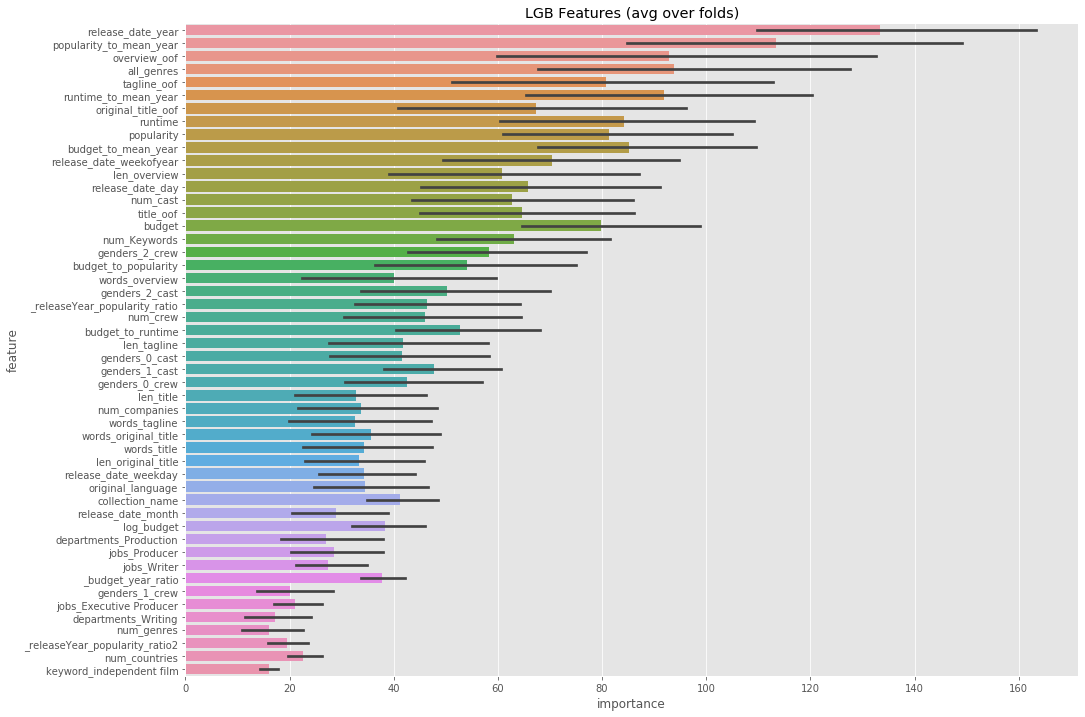

In [97]:
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

#### 重要特征

用shap和eli5看一下重要的特征有哪些

In [98]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.08697	valid_1's rmse: 2.07699
Early stopping, best iteration is:
[1568]	training's rmse: 0.867245	valid_1's rmse: 2.05829


我们可以看到LGB原生的重要特性和ELI5中的顶级特征大致相似。 这意味着我们的模型非常擅长使用这些特征

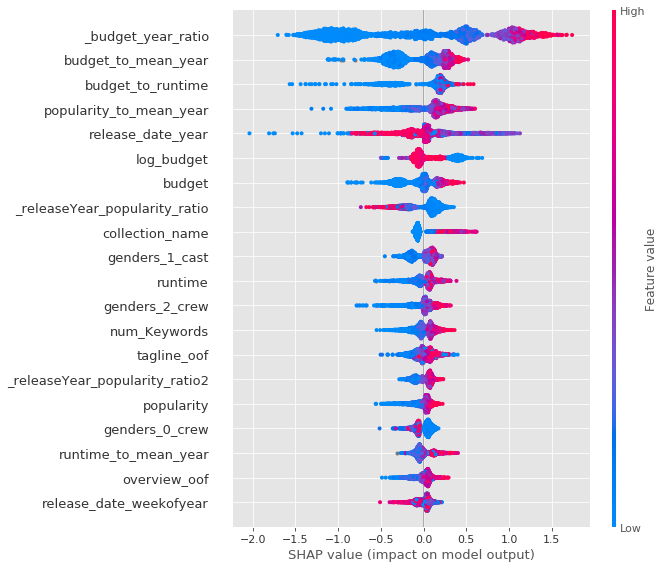

In [99]:
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

SHAP提供更详细的信息，即使它可能更难理解。
例如，低预算对收入产生负面影响，而高价值通常往往会带来更高的收入。

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



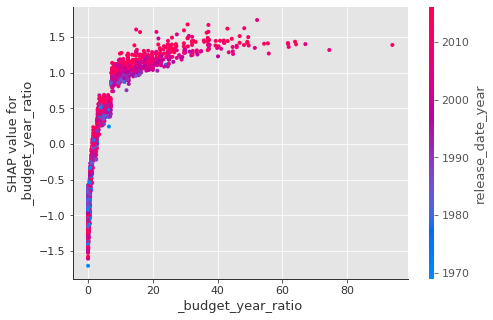

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



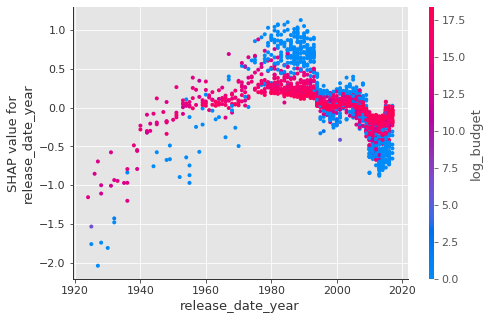

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



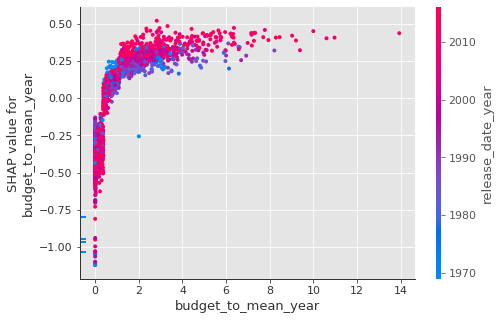

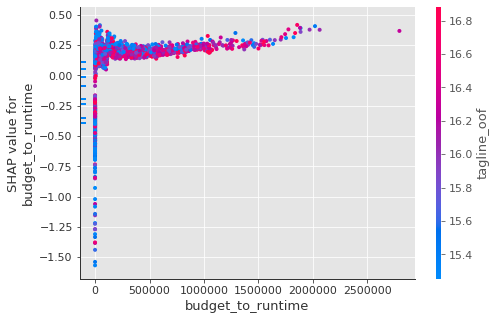

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



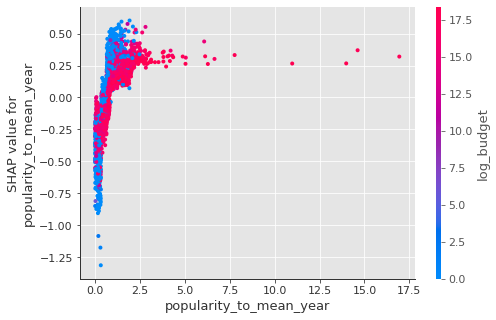

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



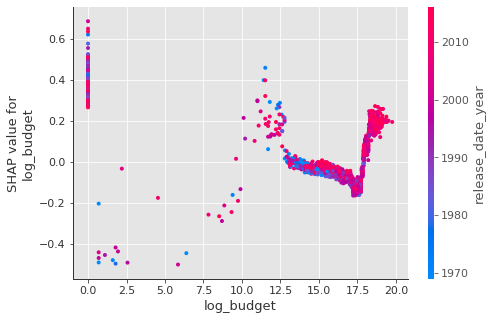

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



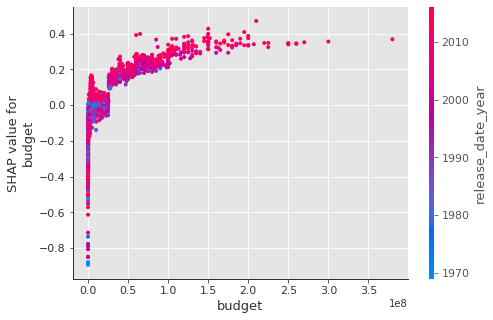

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



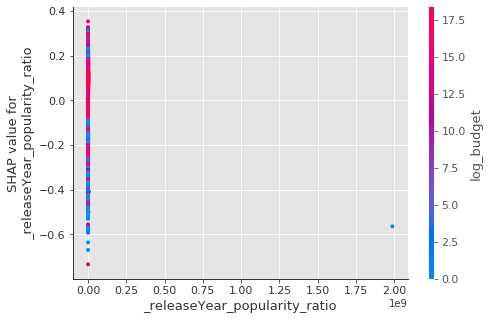

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



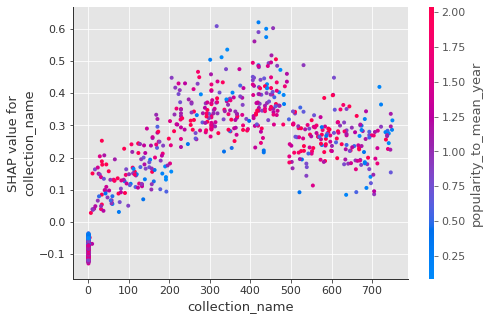

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



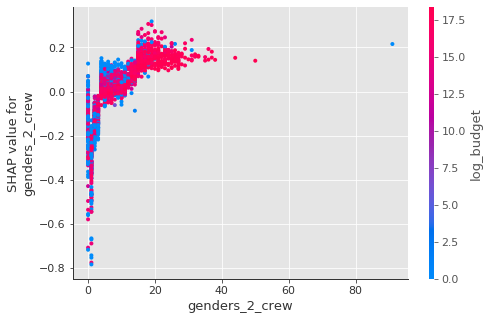

In [100]:
"""
np.argsort:从小打到排序后返回相应值原来的索引
a[::-1]相当于 a[-1:-len(a)-1:-1]，步进为-1，也就是从最后一个元素到第一个元素复制一遍。
"""
top_cols = X_train.columns[np.argsort(shap_values.std(0))[::-1]][:10]
for col in top_cols:
    shap.dependence_plot(col, shap_values, X_train)

在这里我们可以看到重要的特征之间的相互作用。 这里有一些有趣的事情。 例如，release_date_year和log_budget之间的关系。 高达1990年的低预算电影带来了更高的收入，但在2000年之后，高预算往往与更高的收入相关联。 而且在实际情况下，预算的影响减弱了。

让我们创建新特征作为最重要特征之间的交互。 其中一些没有意义，但也许他们可以改进模型。

In [101]:
def top_cols_interaction(df):
    df['budget_to_year'] = df['budget'] / df['release_date_year']
    df['budget_to_mean_year_to_year'] = df['budget_to_mean_year'] / df['release_date_year']
    df['popularity_to_mean_year_to_log_budget'] = df['popularity_to_mean_year'] / df['log_budget']
    df['year_to_log_budget'] = df['release_date_year'] / df['log_budget']
    df['budget_to_runtime_to_year'] = df['budget_to_runtime'] / df['release_date_year']
    df['genders_1_cast_to_log_budget'] = df['genders_1_cast'] / df['log_budget']
    df['all_genres_to_popularity_to_mean_year'] = df['all_genres'] / df['popularity_to_mean_year']
    df['genders_2_crew_to_budget_to_mean_year'] = df['genders_2_crew'] / df['budget_to_mean_year']
    df['overview_oof_to_genders_2_crew'] = df['overview_oof'] / df['genders_2_crew']
    
    return df

In [102]:
X = top_cols_interaction(X)
X_test = top_cols_interaction(X_test)

In [103]:
X = X.replace([np.inf, -np.inf], 0).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

#### external features

从https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat
添加额外的新特征再进行训练

In [104]:
trainAdditionalFeatures = pd.read_csv('./data/TrainAdditionalFeatures.csv')
testAdditionalFeatures = pd.read_csv('./data/TestAdditionalFeatures.csv')

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
X['imdb_id'] = train['imdb_id']
X_test['imdb_id'] = test['imdb_id']
del train, test

X = pd.merge(X, trainAdditionalFeatures, how='left', on=['imdb_id'])
X_test = pd.merge(X_test, testAdditionalFeatures, how='left', on=['imdb_id'])

X = X.drop(['imdb_id'], axis=1)
X_test = X_test.drop(['imdb_id'], axis=1)

Fold 0 started at Thu Nov 28 12:15:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[656]	training's rmse: 1.01423	valid_1's rmse: 1.76191
Fold 1 started at Thu Nov 28 12:15:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[737]	training's rmse: 0.966581	valid_1's rmse: 1.79255
Fold 2 started at Thu Nov 28 12:15:17 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.797173	valid_1's rmse: 1.65141
Early stopping, best iteration is:
[1363]	training's rmse: 0.633381	valid_1's rmse: 1.64744
Fold 3 started at Thu Nov 28 12:15:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[594]	training's rmse: 1.05667	valid_1's rmse: 1.79443
Fold 4 started at Thu Nov 28 12:15:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.800822	valid_1's rmse: 1

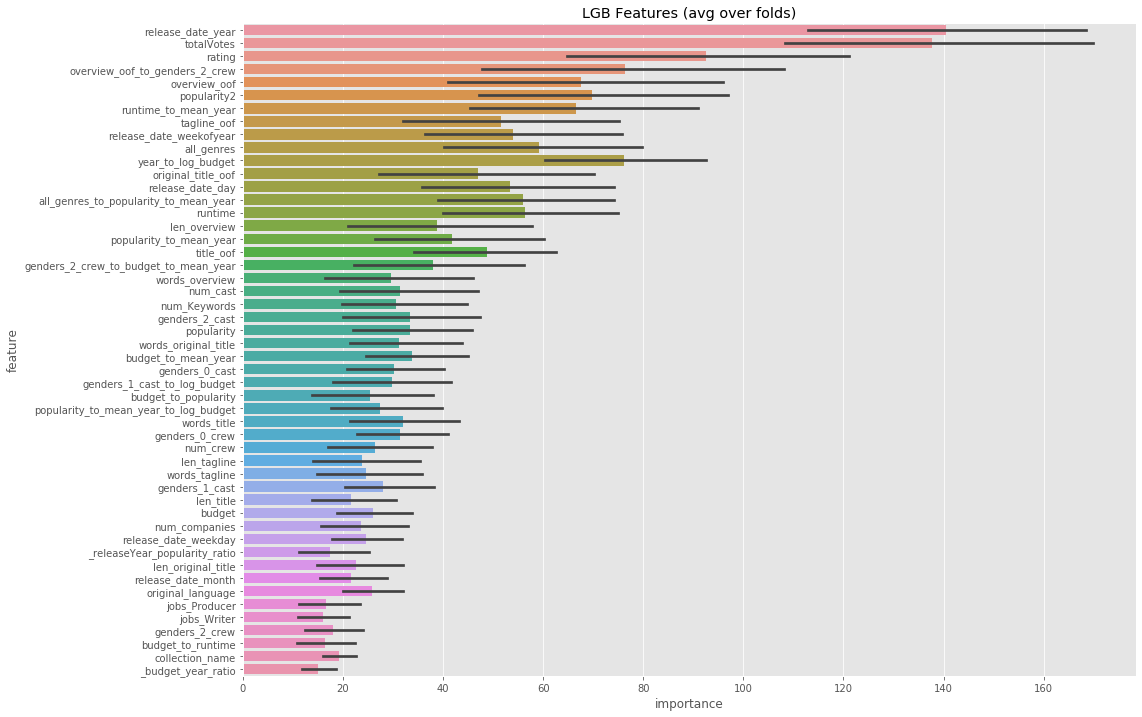

In [105]:
#再次训练lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

#### Blending的方法提升效果

In [106]:
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb, prediction_xgb = train_model(X, X_test, y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Thu Nov 28 12:15:42 2019
[0]	train-rmse:15.5966	valid_data-rmse:15.8994
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.8696	valid_data-rmse:1.74781
[1000]	train-rmse:0.517097	valid_data-rmse:1.72433
[1500]	train-rmse:0.323661	valid_data-rmse:1.72149
Stopping. Best iteration:
[1424]	train-rmse:0.347195	valid_data-rmse:1.72039

Fold 1 started at Thu Nov 28 12:16:46 2019
[0]	train-rmse:15.6274	valid_data-rmse:15.6206
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.866875	valid_data-rmse:1.83325
[1000]	train-rmse:0.522745	valid_data-rmse:1.82216
Stopping. Best iteration:
[928]	train-rmse:0.559427	valid_data-rmse:1.81996

Fold 2 started at Thu Nov 28 12:17:30 2019
[0]	train-rmse:15.6146	valid_data-rmse:15.7355
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.887618	valid_data-rmse:1.6133
[1000]	train-rmse:0.531511	valid_data-rmse:1.57471
[1500]	train-rmse:0.323732	valid_data-rmse:1.56556
[2000]	train-rmse:0.205229	valid_data-rmse:1.56027
[2500]	train-rmse:0.129516	valid_data-rmse:1.55961
Stopping. Best iteration:
[2574]	train-rmse:0.121612	valid_data-rmse:1.55926

Fold 3 started at Thu Nov 28 12:19:21 2019
[0]	train-rmse:15.6479	valid_data-rmse:15.4321
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.879709	valid_data-rmse:1.77177
Stopping. Best iteration:
[668]	train-rmse:0.734189	valid_data-rmse:1.7642

Fold 4 started at Thu Nov 28 12:19:55 2019
[0]	train-rmse:15.6207	valid_data-rmse:15.687
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.875325	valid_data-rmse:1.70291
[1000]	train-rmse:0.512861	valid_data-rmse:1.65615
Stopping. Best iteration:
[1223]	train-rmse:0.414514	valid_data-rmse:1.65237

Fold 5 started at Thu Nov 28 12:20:51 2019
[0]	train-rmse:15.6339	valid_data-rmse:15.5622
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.903176	valid_data-rmse:1.70333
[1000]	train-rmse:0.543284	valid_data-rmse:1.69224
Stopping. Best iteration:
[878]	train-rmse:0.612385	valid_data-rmse:1.69099

Fold 6 started at Thu Nov 28 12:21:34 2019
[0]	train-rmse:15.6194	valid_data-rmse:15.6936
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.848828	valid_data-rmse:2.08174
[1000]	train-rmse:0.49794	valid_data-rmse:2.07269
Stopping. Best iteration:
[1230]	train-rmse:0.398959	valid_data-rmse:2.07215

Fold 7 started at Thu Nov 28 12:22:30 2019
[0]	train-rmse:15.6546	valid_data-rmse:15.3721
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.874722	valid_data-rmse:2.10028
[1000]	train-rmse:0.524175	valid_data-rmse:2.09096
[1500]	train-rmse:0.332991	valid_data-rmse:2.08636
[2000]	train-rmse:0.212748	valid_data-rmse:2.08167
[2500]	train-rmse:0.136087	valid_data-rmse:2.07969
[3000]	train-rmse:0.087473	valid_data-rmse:2.0778
[3500]	train-rmse:0.056143	valid_data-rmse:2.07703
Stopping. Best iteration:
[3751]	train-rmse:0.044745	valid_data-rmse:2.07679

Fold 8 started at Thu Nov 28 12:25:06 2019
[0]	train-rmse:15.6405	valid_data-rmse:15.507
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.886912	valid_data-rmse:1.9816
Stopping. Best iteration:
[768]	train-rmse:0.652776	valid_data-rmse:1.97367

Fold 9 started at Thu Nov 28 12:25:44 2019
[0]	train-rmse:15.6117	valid_data-rmse:15.7612
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[500]	train-rmse:0.857825	valid_data-rmse:1.84018
[1000]	train-rmse:0.507759	valid_data-rmse:1.82209
Stopping. Best iteration:
[1119]	train-rmse:0.451661	valid_data-rmse:1.82079

CV mean score: 1.8151, std: 0.1669.


In [107]:
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat = train_model(X, X_test, y, params=cat_params, model_type='cat')

Fold 0 started at Thu Nov 28 12:26:35 2019
Fold 1 started at Thu Nov 28 12:27:28 2019
Fold 2 started at Thu Nov 28 12:28:13 2019
Fold 3 started at Thu Nov 28 12:29:26 2019
Fold 4 started at Thu Nov 28 12:30:41 2019
Fold 5 started at Thu Nov 28 12:31:32 2019
Fold 6 started at Thu Nov 28 12:32:10 2019
Fold 7 started at Thu Nov 28 12:32:47 2019
Fold 8 started at Thu Nov 28 12:33:51 2019
Fold 9 started at Thu Nov 28 12:34:20 2019
CV mean score: 1.8214, std: 0.1774.


In [109]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, prediction_lgb_1 = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Thu Nov 28 12:36:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.20325	valid_1's rmse: 1.74428
Early stopping, best iteration is:
[1321]	training's rmse: 1.08391	valid_1's rmse: 1.73732
Fold 1 started at Thu Nov 28 12:36:27 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.2127	valid_1's rmse: 1.82884
Early stopping, best iteration is:
[1220]	training's rmse: 1.13594	valid_1's rmse: 1.82534
Fold 2 started at Thu Nov 28 12:36:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.2046	valid_1's rmse: 1.65709
Early stopping, best iteration is:
[1086]	training's rmse: 1.16959	valid_1's rmse: 1.65181
Fold 3 started at Thu Nov 28 12:36:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[709]	training's rmse: 1.3209	valid_1's rmse: 1.77942
Fold 4 started at Thu Nov 28 12:36:33 2019
Train

In [110]:
#另一组参数的lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2, prediction_lgb_2 = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Thu Nov 28 12:38:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[434]	training's rmse: 1.05234	valid_1's rmse: 1.76748
Fold 1 started at Thu Nov 28 12:38:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[346]	training's rmse: 1.17525	valid_1's rmse: 1.83439
Fold 2 started at Thu Nov 28 12:38:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[504]	training's rmse: 0.981231	valid_1's rmse: 1.68453
Fold 3 started at Thu Nov 28 12:38:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[380]	training's rmse: 1.11614	valid_1's rmse: 1.81957
Fold 4 started at Thu Nov 28 12:38:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[625]	training's rmse: 0.8567	valid_1's rmse: 1.6556
Fold 5 started at Thu

#### Stacking

In [111]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_cat, prediction_lgb_1, prediction_lgb_2]).transpose()
test_stack = pd.DataFrame(test_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

Fold 0 started at Thu Nov 28 12:38:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[423]	training's rmse: 1.76337	valid_1's rmse: 1.71275
Fold 1 started at Thu Nov 28 12:38:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[224]	training's rmse: 1.79394	valid_1's rmse: 1.87371
Fold 2 started at Thu Nov 28 12:38:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[603]	training's rmse: 1.75441	valid_1's rmse: 1.57142
Fold 3 started at Thu Nov 28 12:38:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[465]	training's rmse: 1.75104	valid_1's rmse: 1.77657
Fold 4 started at Thu Nov 28 12:38:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 1.81404	valid_1's rmse: 1.68096
Fold 5 started at Th

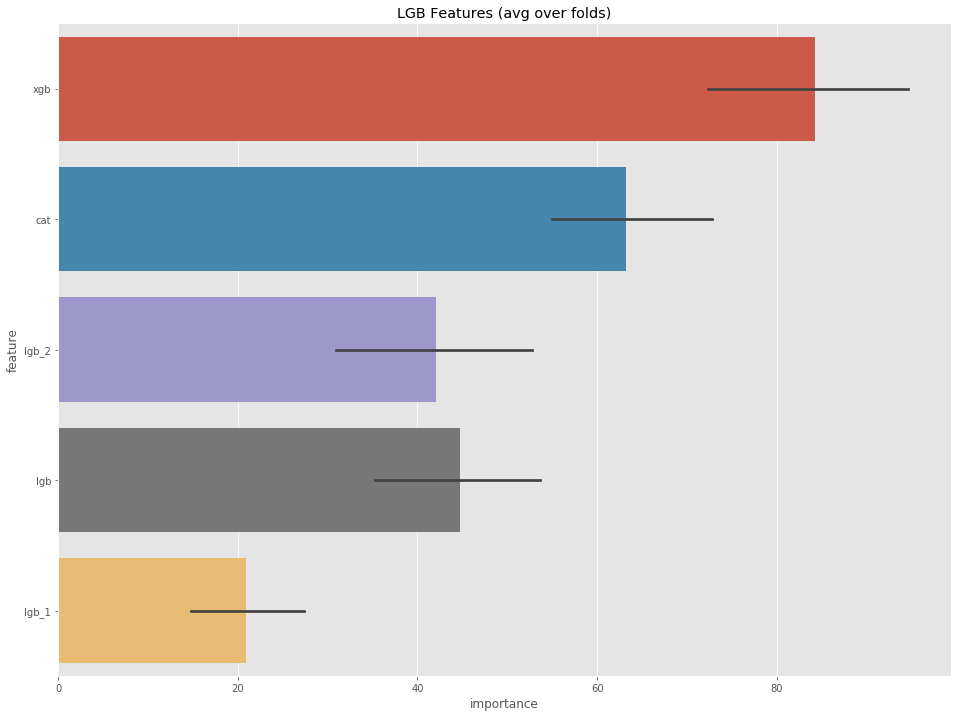

In [112]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack, prediction_lgb_stack, _ = train_model(train_stack, test_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

In [113]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack, prediction_rcv_stack = train_model(train_stack.values, test_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Thu Nov 28 12:38:19 2019
Fold 1 started at Thu Nov 28 12:38:19 2019
Fold 2 started at Thu Nov 28 12:38:19 2019
Fold 3 started at Thu Nov 28 12:38:19 2019
Fold 4 started at Thu Nov 28 12:38:19 2019
Fold 5 started at Thu Nov 28 12:38:19 2019
Fold 6 started at Thu Nov 28 12:38:19 2019
Fold 7 started at Thu Nov 28 12:38:19 2019
Fold 8 started at Thu Nov 28 12:38:20 2019
Fold 9 started at Thu Nov 28 12:38:20 2019
CV mean score: 1.8042, std: 0.1700.


In [114]:
sub = pd.read_csv('./data/sample_submission.csv')
sub['revenue'] = np.expm1(prediction_lgb)
sub.to_csv("lgb.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb) / 2)
sub.to_csv("blend.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat) / 3)
sub.to_csv("blend1.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1) / 4)
sub.to_csv("blend2.csv", index=False)
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat + prediction_lgb_1 + prediction_lgb_2) / 5)
sub.to_csv("blend3.csv", index=False)

sub['revenue'] = prediction_lgb_stack
sub.to_csv("stack_lgb.csv", index=False)
sub['revenue'] = prediction_rcv_stack
sub.to_csv("stack_rcv.csv", index=False)